# Homework 4

## More trains

For this homework, you will be working with the real-time stream of the NS, the train company of the Netherlands. You can see an example webpage that uses this same stream to display the train information on a map: https://spoorkaart.mwnn.nl/ . 

To help you and avoid having too many connections to the NS streaming servers, we have setup a service that collects the streams and pushes them to our Kafka instance. The related topics are: 

`ndovloketnl-arrivals` : For each arrival of a train in a station, describe the previous and next station, time of arrival (planned and actual), track number,...

`ndovloketnl-departures`: For each departure of a train from a station, describe the previous and next station, time of departure (planned and actual), track number,...

`ndovloketnl-gps`: For each train, describe the current location, speed, bearing.

The events are serialized in json (actually converted from xml), with properties in their original language. Google translate could help you understand all of them, but we will provide you some useful mapping.

## Start a Spark Session

In [1]:
import pyspark
from pyspark.sql import SparkSession
import os
import getpass
from pyspark.streaming import StreamingContext
from  pyspark.streaming.kafka import KafkaUtils, OffsetRange

username = getpass.getuser()

# Use this when running on your computer
# spark = (SparkSession
#          .builder
#          .appName('streaming-{0}'.format(username))
#          .master('local[4]') # this number must be greater than the number of sources
#          .config('spark.executor.memory', '1g')
#          .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.2.0')
#          .getOrCreate())

# Use this when running on the cluster
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python'
spark = (SparkSession
         .builder
         .appName('streaming-{0}'.format(username))
         .master('yarn')
         .config('spark.executor.memory', '1g')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .config('spark.port.maxRetries', '100')
         .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.2.0')
         .getOrCreate())

sc = spark.sparkContext
conf = sc.getConf()

spark

## Start a Kafka Client

In [2]:
from pykafka import KafkaClient

ZOOKEEPER_QUORUM = 'iccluster045.iccluster.epfl.ch:2181,iccluster047.iccluster.epfl.ch:2181,iccluster058.iccluster.epfl.ch:2181'

client = KafkaClient(zookeeper_hosts=ZOOKEEPER_QUORUM)

# Preliminary - Data Preparation

## Static RDDs from Kafka

Working on data streams is often times more complex compared to using static datasets, so we will first look at how to create static RDDs for easy prototyping.

You can find below a function that creates a static RDD from a Kafka topic.

In [3]:
def create_static_rdd_from_kafka(topic, from_offset, to_offset):
    if isinstance(topic, bytes):
        topic = topic.decode('utf-8')
    return KafkaUtils.createRDD(sc, {'bootstrap.servers': 'iccluster045.iccluster.epfl.ch:6667'}, [OffsetRange(topic, 0, from_offset, to_offset)])

To check this function, we need to retrieve valid offsets from Kafka.

In [4]:
topic = client.topics[b'ndovloketnl-arrivals']
topic.earliest_available_offsets()

{0: OffsetPartitionResponse(offset=[408075], err=0)}

Now, we can for example retrieve the first 1000 messages from the topic `ndovloketnl-arrivals`.

In [5]:
offset = topic.earliest_available_offsets()[0].offset[0]
rdd = create_static_rdd_from_kafka(b'ndovloketnl-arrivals', offset, offset+1000)

In [6]:
offset

408075

In [7]:
rdd.first()

(None,
 '{"ns1:PutReisInformatieBoodschapIn": {"@xmlns:ns1": "urn:ndov:cdm:trein:reisinformatie:messages:dynamischeaankomststaat:1", "@xmlns:ns2": "urn:ndov:cdm:trein:reisinformatie:data:4", "ns2:ReisInformatieProductDAS": {"@TimeStamp": "2018-04-28T21:07:58.090Z", "@Versie": "6.1", "ns2:RIPAdministratie": {"ns2:ReisInformatieProductID": "1804282307582200002", "ns2:AbonnementId": "55", "ns2:ReisInformatieTijdstip": "2018-04-28T21:07:00.000Z"}, "ns2:DynamischeAankomstStaat": {"ns2:RitId": "7079", "ns2:RitDatum": "2018-04-28", "ns2:RitStation": {"ns2:StationCode": "AML", "ns2:Type": "5", "ns2:KorteNaam": "Almelo", "ns2:MiddelNaam": "Almelo", "ns2:LangeNaam": "Almelo", "ns2:UICCode": "8400051"}, "ns2:TreinAankomst": {"ns2:TreinNummer": "7079", "ns2:TreinSoort": {"@Code": "SPR", "#text": "Sprinter"}, "ns2:TreinStatus": "0", "ns2:Vervoerder": "NS", "ns2:TreinHerkomst": [{"@InfoStatus": "Gepland", "ns2:StationCode": "APD", "ns2:Type": "5", "ns2:KorteNaam": "Apeldoorn", "ns2:MiddelNaam": "Ape

In [8]:
rdd.count()

1000

We encourage you to use these functions to help prototype your code.

## Fetching messages at specific offsets from Kafka

You can find below a function to read a message at a specific offset from a Kafka topic.

In [9]:
def fetch_message_at(topic, offset):
    if isinstance(topic, str):
        topic = topic.encode('utf-8')
    t = client.topics[topic]
    consumer = t.get_simple_consumer()
    p = list(consumer.partitions.values())[0]
    consumer.reset_offsets([(p,int(offset)-1)], )
    return consumer.consume()

In [10]:
msg = fetch_message_at(b'ndovloketnl-arrivals', 408076)

Offset reset for partition 0 to timestamp 408075 failed. Setting partition 0's internal counter to 408075


In [11]:
msg.offset

408076

## Streams from Kafka

In [12]:
# Define the checkpoint folder

# # Use this if working on your computer
# checkpoint = '/tmp/checkpoint'

# Use this if working on the cluster
checkpoint = 'hdfs:///user/{}/checkpoint/'.format(username)

In [92]:
# Create a StreamingContext with two working thread and batch interval of 10 seconds.
# Each time you stop a StreamingContext, you will need to recreate it.
ssc = StreamingContext(sc, 10)
ssc.checkpoint(checkpoint)

group_id = 'ns-{0}'.format(username)

# Input streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, {'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, {'ndovloketnl-departures': 1})
gps_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, {'ndovloketnl-gps': 1})

For now, let's just print the content of the streams.
However sometimes I could not print them out.

In [93]:
arrival_stream.pprint()
departure_stream.pprint()
gps_stream.pprint()

ssc.start()

-------------------------------------------
Time: 2018-05-17 14:03:10
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:10
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:10
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:30
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:30
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:30
----------

In [94]:
ssc.stop(stopSparkContext=False, stopGraceFully=True)

-------------------------------------------
Time: 2018-05-17 14:03:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:50
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:50
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 14:03:50
-------------------------------------------



You will need to adjust the batch interval (10 seconds here) in accordance with the processing times. Use the spark UI to check if batches are not accumulating.

# Part I - Live plot (20 points / 60)

The goal of this part is to obtain an interactive plot use the train positions from the GPS stream. We encourage you to use the examples from last week to achieve the expected result.

First, let's write a function to decode the messages from the `ndovloketnl-gps` topic.

In [42]:
import json
from pykafka.common import OffsetType

example_gps = client.topics[b'ndovloketnl-gps'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST,
    reset_offset_on_start=True
).consume()
json.loads(example_gps.value)

{'tns:ArrayOfTreinLocation': {'@xmlns:tns': 'http://schemas.datacontract.org/2004/07/Cognos.Infrastructure.Models',
  'tns:TreinLocation': [{'tns:TreinMaterieelDelen': [{'tns:AantalSatelieten': '11',
      'tns:Berichttype': None,
      'tns:Bron': 'NTT',
      'tns:Elevation': '0.0',
      'tns:Fix': '1',
      'tns:GpsDatumTijd': '2018-04-28T18:27:26Z',
      'tns:Hdop': '0.9',
      'tns:Latitude': '51.5608216667',
      'tns:Longitude': '5.0829',
      'tns:MaterieelDeelNummer': '4240',
      'tns:Materieelvolgnummer': '1',
      'tns:Orientatie': '0',
      'tns:Richting': '150.96',
      'tns:Snelheid': '0'},
     {'tns:AantalSatelieten': '11',
      'tns:Berichttype': None,
      'tns:Bron': 'NTT',
      'tns:Elevation': '0.0',
      'tns:Fix': '1',
      'tns:GpsDatumTijd': '2018-04-28T18:27:27Z',
      'tns:Hdop': '0.9',
      'tns:Latitude': '51.56064',
      'tns:Longitude': '5.08481666667',
      'tns:MaterieelDeelNummer': '4032',
      'tns:Materieelvolgnummer': '2',
     

We can see that the message has the following structure:

```
{
  'tns:ArrayOfTreinLocation': {
    'tns:TreinLocation': [
      <train_info_1>,
      <train_info_2>,
      ...
    ]
  }
}
```

With the `<train_info_x>` messages containing:
- `tns:TreinNummer`: the train number. This number is used in passenger information displays.
- `tns:MaterieelDeelNummer`: the train car number. It identifies the physical train car.
- `tns:Materieelvolgnummer`: the car position. 1 is the car in front of the train, 2 the next one, etc.
- `tns:GpsDatumTijd`: the datetime given by the GPS.
- `tns:Latitude`, `tns:Longitude`, `tns:Elevation`: 3D coordinates given by the GPS.
- `tns:Snelheid`: speed, most likely given by the GPS.
- `tns:Richting`: heading, most likely given by the GPS.
- `tns:AantalSatelieten`: number of GPS satellites in view.

We also notice that when a train is composed of multiple cars, the position is given in an array, with the position of all individual cars.

**Question I.a. (5/20)** Write a function which extracts the train number, train car and GPS data from the source messages. Using this function, you should be able to obtain the example table, or something similar.

In [43]:
def extract_gps_data(msg):
    temp = msg['tns:ArrayOfTreinLocation']['tns:TreinLocation']
    results = []
    for i in temp:
        treinmateriee = i['tns:TreinMaterieelDelen']
        if isinstance(treinmateriee ,list):
            for j in treinmateriee:
                res = [j['tns:GpsDatumTijd'],int(i['tns:TreinNummer']),\
                       int(j['tns:MaterieelDeelNummer']),int(j['tns:Materieelvolgnummer']),\
                      float(j['tns:Latitude']),float(j['tns:Longitude']),float(j['tns:Elevation']),\
                       float(j['tns:Richting']),float(j['tns:Snelheid'])]
                results.append(res)
        else:
            j = treinmateriee
            res = [j['tns:GpsDatumTijd'],int(i['tns:TreinNummer']),\
                       int(j['tns:MaterieelDeelNummer']),int(j['tns:Materieelvolgnummer']),\
                      float(j['tns:Latitude']),float(j['tns:Longitude']),float(j['tns:Elevation']),\
                       float(j['tns:Richting']),float(j['tns:Snelheid'])]
            results.append(res)
    return results

In [44]:
# Example use of `extract_gps_data`
import numpy as np
import pandas as pd

# I store the 'timestamp' as the Timestamp format without considering time zone.
df = pd.DataFrame(
    data=extract_gps_data(json.loads(example_gps.value)),
    columns=['timestamp', 'train_number', 'car_number', 'car_position', 'latitude', 'longitude', 'elevation', 'heading', 'speed']
)
df.head(20)

,timestamp,train_number,car_number,car_position,latitude,longitude,elevation,heading,speed
0,2018-04-28T18:27:26Z,3671,4240,1,51.560822,5.082900,0.0,150.96,0.0
1,2018-04-28T18:27:27Z,3671,4032,2,51.560640,5.084817,0.0,36.95,0.0
2,2018-04-28T18:27:20Z,4873,2961,1,52.678516,4.899664,0.0,90.90,50.4
3,2018-04-28T18:27:19Z,3674,4064,1,51.595838,4.794563,0.0,86.01,38.0
4,2018-04-28T18:27:28Z,3674,4244,2,51.595838,4.794220,0.0,86.23,51.0
5,2018-04-28T18:27:19Z,3670,4060,1,51.873810,5.858758,0.0,357.03,134.0
6,2018-04-28T18:27:20Z,3670,4241,2,51.873450,5.858803,0.0,357.01,135.0
7,2018-04-28T18:27:21Z,14675,2410,1,52.362052,4.931086,0.0,172.60,43.2
8,2018-04-28T18:27:20Z,3072,9402,1,51.985212,5.900102,0.0,114.24,0.0
9,2018-04-28T18:27:27Z,3170,9576,1,52.106834,5.083323,0.0,313.22,112.0


***One thing I have to mention is that timestamp here is tz-aware axis. In order to get the local time we should convert this tz-aware axis to target time zone. However in the later step, we just keep the timestamp and ignore the tz-axis.***

For example you could convert it as follows:

In [45]:
import pytz
example = pd.Timestamp('2018-04-28 18:27:26+0000', tz='UTC')
print('Kept timestamp in our dataframe:       ',example)
Amsterdam = pytz.timezone('Europe/Amsterdam')
local = example.tz_convert(Amsterdam)
print('Actual timestamp in target time zone:  ',local)

Kept timestamp in our dataframe:        2018-04-28 18:27:26+00:00
Actual timestamp in target time zone:   2018-04-28 20:27:26+02:00


There are two hours gap between two expressions.

**Question I.b (15/20)** Make a live plot of the train positions.

You can do so by using bokeh; use last week's lab as an example.
See also: https://bokeh.pydata.org/en/latest/docs/user_guide/geo.html

To use the maps in bokeh, you will likely need to convert GPS coordinates to web mercator:
https://gis.stackexchange.com/questions/247871/convert-gps-coordinates-to-web-mercator-epsg3857-using-python-pyproj

You can compare your plot to one of the live services: https://spoorkaart.mwnn.nl/, http://treinenradar.nl/

**Care should be taken for the following points.**
- We expect the train positions to fall on rail tracks on the map.
- Trains on the map should not appear/disappear when data is absent for a few messages.
- Provide interactive label with the train number (we do not expect train type, as this needs to be recovered from other sources).
- If possible, find a way to show where the train is heading.

In [46]:
import math

RADIUS = 6378137.0 # in meters on the equator

def lat2y(a):
    return math.log(math.tan(math.pi / 4 + math.radians(a) / 2)) * RADIUS

def lon2x(a):
    return math.radians(a) * RADIUS

We provide interactive label including the train_number and the heading directions.

When a train is absent from more than 20 messages, we think this train arrived its destination and we will not plot them anymore until we receive the message including this train again.

In [47]:
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.plotting import gmap
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Range1d
import time
from bokeh.models import HoverTool
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead
output_notebook()

x=[]
y=[]
heading=[]
train_nb=[]
x_end=[]
y_end=[]
source = ColumnDataSource(data=dict(longitude=x, latitude=y,train_nb=train_nb,heading=heading,x_end=x_end,y_end=y_end))


p = figure(title="Real-time train status of the NS",y_range=(6533321,7076025), x_range=(333958, 890555),
           x_axis_type="mercator", y_axis_type="mercator")
p.add_tile(CARTODBPOSITRON)


p.circle('longitude','latitude', source=source, color='red', line_width=3)

# Interactive label
my_hover = HoverTool()
my_hover.tooltips = [('Train nb','@train_nb'),('heading','@heading')]
p.add_tools(my_hover)


# Heading direction
p.add_layout(
        Arrow(end=VeeHead(size=3), line_color="blue", x_start='longitude', y_start='latitude', x_end='x_end',
        y_end='y_end', source=source))
handle=show(p, notebook_handle=True)


consumer = client.topics[b'ndovloketnl-gps'].get_simple_consumer()


# Up-to-date position information about trains 
d = dict()
# record the times of continuously disappeared train
# if frequency is 0 means we receive the message about this train's position
# if frequency is rather than 0 such like 4 means we have not received any messages from this train in past 4 messages.
freq = dict()
try:
    for message in consumer:
        if message is not None:
            
            msgs = pd.DataFrame(
                data=extract_gps_data(json.loads(message.value)),
                columns=['timestamp', 'train_number', 'car_number', 'car_position', 'latitude', 'longitude', 'elevation', 'heading', 'speed']
            )

            msgs = msgs[msgs['latitude']!=0]
            
            train_appear = set()
            # first message and create the dict
            for i in range(len(msgs)):
                msg = msgs.iloc[i]
                # update the dict
                d[msg['train_number']] = [msg['latitude'],msg['longitude'],msg['heading']]
                train_appear.add(msg['train_number'])
            # for new train, record it
            for i in train_appear:
                if i not in freq:
                    freq[i]=0
            # count the disappeared train
            delete = set()
            for i in freq:
                if i in train_appear:
                    freq[i] = 0
                else:
                    freq[i] +=1
                if freq[i]>20:
                    delete.add(i)
            # del the train disappeared for more than 20 times.
            for i in delete:
                del d[i]
                del freq[i]
                
            xx = []
            yy = []
            nb = []
            hhead = []
            yy_end=[]
            xx_end=[]
            for i in d:
                yy.append(lat2y(d[i][0]))
                yy_end.append(lat2y(d[i][0]+0.05*np.sin(np.deg2rad(-d[i][2]+90))))
                xx.append(lon2x(d[i][1]))
                xx_end.append(lon2x(d[i][1]+0.05*np.cos(np.deg2rad(-d[i][2]+90))))
                nb.append(i)
                hhead.append(d[i][2])
            source.data = dict(longitude=xx, latitude=yy,train_nb=nb,heading=hhead,x_end=xx_end,y_end=yy_end)
            push_notebook(handle=handle)
            time.sleep(0.1)
except KeyboardInterrupt:
    pass

Loading BokehJS ...

# Part II - Live stopping time (20 points / 60)

In this part, we will have a look at the two other streams, namely `ndovloketnl-arrivals` and `ndovloketnl-departures`. Each time a train arrives at or leaves a station, a message is generated. Let's have a look at the content.

In [48]:
example_arrivals = client.topics[b'ndovloketnl-arrivals'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST,
    reset_offset_on_start=True
).consume()
json.loads(example_arrivals.value)

{'ns1:PutReisInformatieBoodschapIn': {'@xmlns:ns1': 'urn:ndov:cdm:trein:reisinformatie:messages:dynamischeaankomststaat:1',
  '@xmlns:ns2': 'urn:ndov:cdm:trein:reisinformatie:data:4',
  'ns2:ReisInformatieProductDAS': {'@TimeStamp': '2018-04-28T21:07:58.090Z',
   '@Versie': '6.1',
   'ns2:DynamischeAankomstStaat': {'ns2:RitDatum': '2018-04-28',
    'ns2:RitId': '7079',
    'ns2:RitStation': {'ns2:KorteNaam': 'Almelo',
     'ns2:LangeNaam': 'Almelo',
     'ns2:MiddelNaam': 'Almelo',
     'ns2:StationCode': 'AML',
     'ns2:Type': '5',
     'ns2:UICCode': '8400051'},
    'ns2:TreinAankomst': {'ns2:AankomstTijd': [{'#text': '2018-04-28T21:07:00.000Z',
       '@InfoStatus': 'Gepland'},
      {'#text': '2018-04-28T21:10:12.000Z', '@InfoStatus': 'Actueel'}],
     'ns2:ExacteAankomstVertraging': 'PT3M12S',
     'ns2:GedempteAankomstVertraging': 'PT5M',
     'ns2:PresentatieAankomstVertraging': {'ns2:Uitingen': {'ns2:Uiting': '+3 min.'}},
     'ns2:PresentatieTreinAankomstSpoor': {'ns2:Uitinge

In [49]:
example_departures = client.topics[b'ndovloketnl-departures'].get_simple_consumer(
    auto_offset_reset=OffsetType.EARLIEST,
    reset_offset_on_start=True
).consume()
json.loads(example_departures.value)

{'ns1:PutReisInformatieBoodschapIn': {'@xmlns:ns1': 'urn:ndov:cdm:trein:reisinformatie:messages:5',
  '@xmlns:ns2': 'urn:ndov:cdm:trein:reisinformatie:data:4',
  'ns2:ReisInformatieProductDVS': {'@TimeStamp': '2018-04-29T12:06:35.345Z',
   '@Versie': '6.2',
   'ns2:DynamischeVertrekStaat': {'ns2:RitDatum': '2018-04-29',
    'ns2:RitId': '5144',
    'ns2:RitStation': {'ns2:KorteNaam': 'Rotterdam',
     'ns2:LangeNaam': 'Rotterdam Centraal',
     'ns2:MiddelNaam': 'Rotterdam C.',
     'ns2:StationCode': 'RTD',
     'ns2:Type': '6',
     'ns2:UICCode': '8400530'},
    'ns2:Trein': {'ns2:AchterBlijvenAchtersteTreinDeel': 'N',
     'ns2:AfstandPerronEindKopVertrekTrein': '0',
     'ns2:ExacteVertrekVertraging': 'PT0S',
     'ns2:GedempteVertrekVertraging': 'PT0S',
     'ns2:NietInstappen': 'N',
     'ns2:PresentatieTreinEindBestemming': {'ns2:Uitingen': {'ns2:Uiting': 'Den Haag Centraal'}},
     'ns2:PresentatieTreinVertrekSpoor': {'ns2:Uitingen': {'ns2:Uiting': '9'}},
     'ns2:Presentatie

We can see that the messages have the following structure:

```
{
  'ns1:PutReisInformatieBoodschapIn': {
    'ns2:ReisInformatieProductDVS' or 'ns2:ReisInformatieProductDAS': {
      'ns2:DynamischeVertrekStaat' or 'ns2:DynamischeAankomstStaat': {
          'ns2:RitStation': <station_info>,
          'ns2:Trein' or 'ns2:TreinAankomst': {
              'ns2:VertrekTijd' or 'ns2:AankomstTijd': [<planned_and_actual_times>],
              'ns2:TreinNummer': <train_number>,
              'ns2:TreinSoort': <kind_of_train>,
              ...
          }
           
      }
    }
  }
}
```

We can see also that the train stations have a long name, a medium name, a short name, a three letters code and a kind of nummerical ID. When giving information about times, tracks, direction,... you will find sometimes the information twice with the status `Gepland` (which means planned, according to the schedule) and `Actueel`(which means the actual measured value). 

**Question II.a. (5/20)** We want to compute the time a train stays at a station and get a real-time histogram for a given time window. First, write the parsing functions that will allow you to get the station ID and a name, the train ID, and the actual arrival and departure times.

In [50]:
def extract_info_arr(msg):
    temp = msg['ns1:PutReisInformatieBoodschapIn']['ns2:ReisInformatieProductDAS']['ns2:DynamischeAankomstStaat']
    stationID = int(int(temp['ns2:RitStation']['ns2:UICCode']))
    stationName = temp['ns2:RitStation']['ns2:LangeNaam']
    temp2 = temp['ns2:TreinAankomst']
    trainID = int(temp2['ns2:TreinNummer'])
    arrival_time = temp2['ns2:AankomstTijd'][1]['#text']
    return {'T_id':trainID,'St_id':stationID,'St_Name':stationName,'Ar_time':arrival_time}

In [51]:
def extract_info_dep(msg):
    temp = msg['ns1:PutReisInformatieBoodschapIn']['ns2:ReisInformatieProductDVS']['ns2:DynamischeVertrekStaat']
    stationID = int(int(temp['ns2:RitStation']['ns2:UICCode']))
    stationName = temp['ns2:RitStation']['ns2:LangeNaam']
    temp2 = temp['ns2:Trein']
    trainID = int(temp2['ns2:TreinNummer'])
    departure_time = temp2['ns2:VertrekTijd'][1]['#text']
    return {'T_id':trainID,'St_id':stationID,'St_Name':stationName,'De_time':departure_time}

**Question II.b. (5/20)** Create two Spark streams from the arrivals and departures where the records are in the form (K, V) where K is a key that you will be using to join the two streams (think about what you will need to match) and V, the value containing the all extracted information.

In [68]:
ssc = StreamingContext(sc, 20)
ssc.checkpoint(checkpoint)

group_id = 'ns-{0}'.format(username)

# Input streams
arrival_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, {'ndovloketnl-arrivals': 1})
departure_stream = KafkaUtils.createStream(ssc, ZOOKEEPER_QUORUM, group_id, {'ndovloketnl-departures': 1})

# Extract useful information from original stream.
arrival_stream_info = arrival_stream.map(lambda x: \
                                ((str(extract_info_arr(json.loads(x[1]))['St_id']),
                                 str(extract_info_arr(json.loads(x[1]))['T_id'])),\
                                 extract_info_arr(json.loads(x[1]))))
departure_stream_info =departure_stream.map(lambda x: \
                                ((str(extract_info_dep(json.loads(x[1]))['St_id']),
                                 str(extract_info_dep(json.loads(x[1]))['T_id'])),\
                                 extract_info_dep(json.loads(x[1]))))

**Question II.c. (5/20)** Apply a window (possibly of different lengths, but both with 20s sliding interval) on each stream. 
Join the streams such that all stays of 5 minutes and less are captured by the join in the same RDD (you can ignore late messages) and two consecutive joined RDD don't overlap in terms of stays.

This might exists that one train in the same station have several arrival or depatural time. In our case, we keep the latest message which might give us the up-to-date information about that train.



Because the sliding interval is 20 seconds, we set the processing time to 20 seconds as well.
In order to get the stay time which is less than 5 minutes, we windowed the arrival_stream and departure_stream using different window length, 20 seconds and 320 seconds respectively. In that way we could defintely get all stay time which are less than 5 minutes. However there is some risk that the stay time is greater than 5 minutes. For example, if one train arrived at the beginning of one windowed stream but depatured at the end of the corresponding windowed_departure_stream, then the stay time of this train is greater than 5 minutes.

In [58]:
window_arrival_stream = arrival_stream_info.reduceByKeyAndWindow(lambda x,y:y,20,20)
window_departure_stream = departure_stream_info.reduceByKeyAndWindow(lambda x,y:y,320,20)
joined_stream = window_arrival_stream.join(window_departure_stream)

**Question II.d. (5/20)** On the joined stream, compute the length of each stay (you can round to the minute) and produce a stream of histograms. You don't need to plot them, a value/count array is enough. 

In [54]:
timedelta = joined_stream.map(lambda x: \
            (round((pd.Timestamp(x[1][1]['De_time'])-pd.Timestamp(x[1][0]['Ar_time'])).seconds/60),1) 
            if pd.Timestamp(x[1][1]['De_time'])>=pd.Timestamp(x[1][0]['Ar_time']) else ('Negative_stay_time',1))

histogram = timedelta.reduceByKey(lambda x,y:x+y)

However, There are two 'abnormal' situation when capturing messages.
- Stay time which is greater than 5 minutes. 

As some trains might produce messages later rather than in the right stream time, we got this kind of messages in next stream. In that way, it is possible to get few 'abnormal-data'.
- Negative stay time.

This is because for some unknown reasons, the depature time of one train in one station is less than the arrival time. We deal with this kind of data as 'Negative_stay_time' and count them.

In [55]:
histogram.pprint()
ssc.start()      

-------------------------------------------
Time: 2018-05-17 13:46:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:46:40
-------------------------------------------



In [70]:
ssc.stop(stopSparkContext=False, stopGraceFully=True)

-------------------------------------------
Time: 2018-05-17 13:54:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:20
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:40
-------------------------------------------

-------------------------------------------
Time: 2018-05-17 13:54:40
-------------------------------------------



# Part III - Uptime analysis (20 points / 60)

In this part, we will use the available data to derive information about train operations.

**Question III.a (5/20)** Write a function to extract the median timestamp from a message of the `ndovloketnl-gps` topic. You can reuse the `extract_gps_data` function from part I.

Here we just use index = len(time)//2 to select the median without consideration of odd or even length of the table.

In [77]:
import numpy as np
def extract_gps_time_approx(msg):
    df = pd.DataFrame(
    data= extract_gps_data(msg),
    columns=['timestamp', 'train_number', 'car_number', 'car_position', 'latitude', 'longitude', 'elevation', 'heading', 'speed']
)
    
    # Just ignore the tz axis. 
    # But according to the past analysis, we know there exists 2 hours gap between the presented one and local time
    time = df['timestamp'].apply(lambda x: pd.Timestamp(x).tz_convert(None)).sort_values()
    median = time.iloc[len(time)//2]
# When length is even, we could consider the following:
#     median = (time.iloc[len(time)//2]-time.iloc[len(time)//2-1])/2 + time.iloc[len(time)//2-1]
    return np.datetime64(median)

In [78]:
extract_gps_time_approx(json.loads(example_gps.value))

numpy.datetime64('2018-04-28T18:27:23.000000')

**Question III.b (5/20)** Using `fetch_message_at` and `extract_gps_time_approx`, write a function named `search_gps` to find the first offset for a given timestamp in the `ndovloketnl-gps` topic.

More preciseley, if we note `offset = search_gps(ts)` where ts is a timestamp, then we have:
```
ts <= extract_gps_time_approx(fetch_message_at('ndovloketnl-gps', offset))
extract_gps_time_approx(fetch_message_at('ndovloketnl-gps', offset - 1)) < ts
```

In [79]:
# offset_s is start offset which you can set or not.
# If offset_s is empty, the start offset should be the earliest abaliable offset
def search_gps(ts,offset_s=0):
    topic = client.topics[b'ndovloketnl-gps']
    if offset_s==0:
        offset_0 = topic.earliest_available_offsets()[0].offset[0]
        offset = offset_0
    else:
        offset = offset_s
    while ts> extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', offset).value)):
        offset +=1
    return offset

In [82]:
# Example results from `search_gps`
search_gps(pd.Timestamp('2018-05-05'),69610)

Offset reset for partition 0 to timestamp 69609 failed. Setting partition 0's internal counter to 69609
Offset reset for partition 0 to timestamp 69610 failed. Setting partition 0's internal counter to 69610
Offset reset for partition 0 to timestamp 69611 failed. Setting partition 0's internal counter to 69611
Offset reset for partition 0 to timestamp 69612 failed. Setting partition 0's internal counter to 69612
Offset reset for partition 0 to timestamp 69613 failed. Setting partition 0's internal counter to 69613
Offset reset for partition 0 to timestamp 69614 failed. Setting partition 0's internal counter to 69614
Offset reset for partition 0 to timestamp 69615 failed. Setting partition 0's internal counter to 69615
Offset reset for partition 0 to timestamp 69616 failed. Setting partition 0's internal counter to 69616


69617

In [83]:
extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', 69617).value))

Offset reset for partition 0 to timestamp 69616 failed. Setting partition 0's internal counter to 69616


numpy.datetime64('2018-05-05T00:00:03.000000')

In [84]:
extract_gps_time_approx(json.loads(fetch_message_at('ndovloketnl-gps', 69617-1).value))

Offset reset for partition 0 to timestamp 69615 failed. Setting partition 0's internal counter to 69615


numpy.datetime64('2018-05-04T23:59:53.000000')

**Question III.c (5/20)** Using `search_gps`, create a spark RDD or dataframe containing the GPS data between `2018-05-02 23:00:00` and `2018-05-04 01:00:00` (covers May 3rd, with 1h margin). Your extract needs to contain the following fields: `timestamp`, `train_number`, `car_number`, `speed`.

Now, filter on the `timestamp` field to only keep data between `2018-05-03 00:00:00` and `2018-05-04 00:00:00`.

Note: you may find it useful to save the resulting dataset on disk.

In [85]:
timedelta = pd.Timedelta(hours=1)
time = pd.Timestamp('2018-05-02 23:00:00')
# I Just set a start offset for reducing time.
offset = [51976]
while time<=pd.Timestamp('2018-05-04 01:00:00'):
    # If you want search from the earlist offset you can just use search_gps(time)
    offset.append(search_gps(time,offset[-1]))
    time +=timedelta

Offset reset for partition 0 to timestamp 51975 failed. Setting partition 0's internal counter to 51975
Offset reset for partition 0 to timestamp 51976 failed. Setting partition 0's internal counter to 51976
Offset reset for partition 0 to timestamp 51976 failed. Setting partition 0's internal counter to 51976
Offset reset for partition 0 to timestamp 51977 failed. Setting partition 0's internal counter to 51977
Offset reset for partition 0 to timestamp 51978 failed. Setting partition 0's internal counter to 51978
Offset reset for partition 0 to timestamp 51979 failed. Setting partition 0's internal counter to 51979
Offset reset for partition 0 to timestamp 51980 failed. Setting partition 0's internal counter to 51980
Offset reset for partition 0 to timestamp 51981 failed. Setting partition 0's internal counter to 51981
Offset reset for partition 0 to timestamp 51982 failed. Setting partition 0's internal counter to 51982
Offset reset for partition 0 to timestamp 51983 failed. Setting 

Offset reset for partition 0 to timestamp 52053 failed. Setting partition 0's internal counter to 52053
Offset reset for partition 0 to timestamp 52054 failed. Setting partition 0's internal counter to 52054
Offset reset for partition 0 to timestamp 52055 failed. Setting partition 0's internal counter to 52055
Offset reset for partition 0 to timestamp 52056 failed. Setting partition 0's internal counter to 52056
Offset reset for partition 0 to timestamp 52057 failed. Setting partition 0's internal counter to 52057
Offset reset for partition 0 to timestamp 52058 failed. Setting partition 0's internal counter to 52058
Offset reset for partition 0 to timestamp 52059 failed. Setting partition 0's internal counter to 52059
Offset reset for partition 0 to timestamp 52060 failed. Setting partition 0's internal counter to 52060
Offset reset for partition 0 to timestamp 52061 failed. Setting partition 0's internal counter to 52061
Offset reset for partition 0 to timestamp 52062 failed. Setting 

Offset reset for partition 0 to timestamp 52132 failed. Setting partition 0's internal counter to 52132
Offset reset for partition 0 to timestamp 52133 failed. Setting partition 0's internal counter to 52133
Offset reset for partition 0 to timestamp 52134 failed. Setting partition 0's internal counter to 52134
Offset reset for partition 0 to timestamp 52135 failed. Setting partition 0's internal counter to 52135
Offset reset for partition 0 to timestamp 52136 failed. Setting partition 0's internal counter to 52136
Offset reset for partition 0 to timestamp 52137 failed. Setting partition 0's internal counter to 52137
Offset reset for partition 0 to timestamp 52138 failed. Setting partition 0's internal counter to 52138
Offset reset for partition 0 to timestamp 52139 failed. Setting partition 0's internal counter to 52139
Offset reset for partition 0 to timestamp 52140 failed. Setting partition 0's internal counter to 52140
Offset reset for partition 0 to timestamp 52141 failed. Setting 

Offset reset for partition 0 to timestamp 52211 failed. Setting partition 0's internal counter to 52211
Offset reset for partition 0 to timestamp 52212 failed. Setting partition 0's internal counter to 52212
Offset reset for partition 0 to timestamp 52213 failed. Setting partition 0's internal counter to 52213
Offset reset for partition 0 to timestamp 52214 failed. Setting partition 0's internal counter to 52214
Offset reset for partition 0 to timestamp 52215 failed. Setting partition 0's internal counter to 52215
Offset reset for partition 0 to timestamp 52216 failed. Setting partition 0's internal counter to 52216
Offset reset for partition 0 to timestamp 52217 failed. Setting partition 0's internal counter to 52217
Offset reset for partition 0 to timestamp 52218 failed. Setting partition 0's internal counter to 52218
Offset reset for partition 0 to timestamp 52219 failed. Setting partition 0's internal counter to 52219
Offset reset for partition 0 to timestamp 52220 failed. Setting 

Offset reset for partition 0 to timestamp 52290 failed. Setting partition 0's internal counter to 52290
Offset reset for partition 0 to timestamp 52291 failed. Setting partition 0's internal counter to 52291
Offset reset for partition 0 to timestamp 52292 failed. Setting partition 0's internal counter to 52292
Offset reset for partition 0 to timestamp 52293 failed. Setting partition 0's internal counter to 52293
Offset reset for partition 0 to timestamp 52294 failed. Setting partition 0's internal counter to 52294
Offset reset for partition 0 to timestamp 52295 failed. Setting partition 0's internal counter to 52295
Offset reset for partition 0 to timestamp 52296 failed. Setting partition 0's internal counter to 52296
Offset reset for partition 0 to timestamp 52297 failed. Setting partition 0's internal counter to 52297
Offset reset for partition 0 to timestamp 52298 failed. Setting partition 0's internal counter to 52298
Offset reset for partition 0 to timestamp 52299 failed. Setting 

Offset reset for partition 0 to timestamp 52368 failed. Setting partition 0's internal counter to 52368
Offset reset for partition 0 to timestamp 52369 failed. Setting partition 0's internal counter to 52369
Offset reset for partition 0 to timestamp 52370 failed. Setting partition 0's internal counter to 52370
Offset reset for partition 0 to timestamp 52371 failed. Setting partition 0's internal counter to 52371
Offset reset for partition 0 to timestamp 52372 failed. Setting partition 0's internal counter to 52372
Offset reset for partition 0 to timestamp 52373 failed. Setting partition 0's internal counter to 52373
Offset reset for partition 0 to timestamp 52374 failed. Setting partition 0's internal counter to 52374
Offset reset for partition 0 to timestamp 52375 failed. Setting partition 0's internal counter to 52375
Offset reset for partition 0 to timestamp 52376 failed. Setting partition 0's internal counter to 52376
Offset reset for partition 0 to timestamp 52377 failed. Setting 

Offset reset for partition 0 to timestamp 52447 failed. Setting partition 0's internal counter to 52447
Offset reset for partition 0 to timestamp 52448 failed. Setting partition 0's internal counter to 52448
Offset reset for partition 0 to timestamp 52449 failed. Setting partition 0's internal counter to 52449
Offset reset for partition 0 to timestamp 52450 failed. Setting partition 0's internal counter to 52450
Offset reset for partition 0 to timestamp 52451 failed. Setting partition 0's internal counter to 52451
Offset reset for partition 0 to timestamp 52452 failed. Setting partition 0's internal counter to 52452
Offset reset for partition 0 to timestamp 52453 failed. Setting partition 0's internal counter to 52453
Offset reset for partition 0 to timestamp 52454 failed. Setting partition 0's internal counter to 52454
Offset reset for partition 0 to timestamp 52455 failed. Setting partition 0's internal counter to 52455
Offset reset for partition 0 to timestamp 52456 failed. Setting 

Offset reset for partition 0 to timestamp 52526 failed. Setting partition 0's internal counter to 52526
Offset reset for partition 0 to timestamp 52527 failed. Setting partition 0's internal counter to 52527
Offset reset for partition 0 to timestamp 52528 failed. Setting partition 0's internal counter to 52528
Offset reset for partition 0 to timestamp 52529 failed. Setting partition 0's internal counter to 52529
Offset reset for partition 0 to timestamp 52530 failed. Setting partition 0's internal counter to 52530
Offset reset for partition 0 to timestamp 52531 failed. Setting partition 0's internal counter to 52531
Offset reset for partition 0 to timestamp 52532 failed. Setting partition 0's internal counter to 52532
Offset reset for partition 0 to timestamp 52533 failed. Setting partition 0's internal counter to 52533
Offset reset for partition 0 to timestamp 52534 failed. Setting partition 0's internal counter to 52534
Offset reset for partition 0 to timestamp 52535 failed. Setting 

Offset reset for partition 0 to timestamp 52605 failed. Setting partition 0's internal counter to 52605
Offset reset for partition 0 to timestamp 52606 failed. Setting partition 0's internal counter to 52606
Offset reset for partition 0 to timestamp 52607 failed. Setting partition 0's internal counter to 52607
Offset reset for partition 0 to timestamp 52608 failed. Setting partition 0's internal counter to 52608
Offset reset for partition 0 to timestamp 52609 failed. Setting partition 0's internal counter to 52609
Offset reset for partition 0 to timestamp 52610 failed. Setting partition 0's internal counter to 52610
Offset reset for partition 0 to timestamp 52611 failed. Setting partition 0's internal counter to 52611
Offset reset for partition 0 to timestamp 52612 failed. Setting partition 0's internal counter to 52612
Offset reset for partition 0 to timestamp 52613 failed. Setting partition 0's internal counter to 52613
Offset reset for partition 0 to timestamp 52614 failed. Setting 

Offset reset for partition 0 to timestamp 52684 failed. Setting partition 0's internal counter to 52684
Offset reset for partition 0 to timestamp 52685 failed. Setting partition 0's internal counter to 52685
Offset reset for partition 0 to timestamp 52686 failed. Setting partition 0's internal counter to 52686
Offset reset for partition 0 to timestamp 52687 failed. Setting partition 0's internal counter to 52687
Offset reset for partition 0 to timestamp 52688 failed. Setting partition 0's internal counter to 52688
Offset reset for partition 0 to timestamp 52689 failed. Setting partition 0's internal counter to 52689
Offset reset for partition 0 to timestamp 52690 failed. Setting partition 0's internal counter to 52690
Offset reset for partition 0 to timestamp 52691 failed. Setting partition 0's internal counter to 52691
Offset reset for partition 0 to timestamp 52692 failed. Setting partition 0's internal counter to 52692
Offset reset for partition 0 to timestamp 52693 failed. Setting 

Offset reset for partition 0 to timestamp 52762 failed. Setting partition 0's internal counter to 52762
Offset reset for partition 0 to timestamp 52763 failed. Setting partition 0's internal counter to 52763
Offset reset for partition 0 to timestamp 52764 failed. Setting partition 0's internal counter to 52764
Offset reset for partition 0 to timestamp 52765 failed. Setting partition 0's internal counter to 52765
Offset reset for partition 0 to timestamp 52766 failed. Setting partition 0's internal counter to 52766
Offset reset for partition 0 to timestamp 52767 failed. Setting partition 0's internal counter to 52767
Offset reset for partition 0 to timestamp 52768 failed. Setting partition 0's internal counter to 52768
Offset reset for partition 0 to timestamp 52769 failed. Setting partition 0's internal counter to 52769
Offset reset for partition 0 to timestamp 52770 failed. Setting partition 0's internal counter to 52770
Offset reset for partition 0 to timestamp 52771 failed. Setting 

Offset reset for partition 0 to timestamp 52841 failed. Setting partition 0's internal counter to 52841
Offset reset for partition 0 to timestamp 52842 failed. Setting partition 0's internal counter to 52842
Offset reset for partition 0 to timestamp 52843 failed. Setting partition 0's internal counter to 52843
Offset reset for partition 0 to timestamp 52844 failed. Setting partition 0's internal counter to 52844
Offset reset for partition 0 to timestamp 52845 failed. Setting partition 0's internal counter to 52845
Offset reset for partition 0 to timestamp 52846 failed. Setting partition 0's internal counter to 52846
Offset reset for partition 0 to timestamp 52847 failed. Setting partition 0's internal counter to 52847
Offset reset for partition 0 to timestamp 52848 failed. Setting partition 0's internal counter to 52848
Offset reset for partition 0 to timestamp 52849 failed. Setting partition 0's internal counter to 52849
Offset reset for partition 0 to timestamp 52850 failed. Setting 

Offset reset for partition 0 to timestamp 52920 failed. Setting partition 0's internal counter to 52920
Offset reset for partition 0 to timestamp 52921 failed. Setting partition 0's internal counter to 52921
Offset reset for partition 0 to timestamp 52922 failed. Setting partition 0's internal counter to 52922
Offset reset for partition 0 to timestamp 52923 failed. Setting partition 0's internal counter to 52923
Offset reset for partition 0 to timestamp 52924 failed. Setting partition 0's internal counter to 52924
Offset reset for partition 0 to timestamp 52925 failed. Setting partition 0's internal counter to 52925
Offset reset for partition 0 to timestamp 52926 failed. Setting partition 0's internal counter to 52926
Offset reset for partition 0 to timestamp 52927 failed. Setting partition 0's internal counter to 52927
Offset reset for partition 0 to timestamp 52928 failed. Setting partition 0's internal counter to 52928
Offset reset for partition 0 to timestamp 52929 failed. Setting 

Offset reset for partition 0 to timestamp 52999 failed. Setting partition 0's internal counter to 52999
Offset reset for partition 0 to timestamp 53000 failed. Setting partition 0's internal counter to 53000
Offset reset for partition 0 to timestamp 53001 failed. Setting partition 0's internal counter to 53001
Offset reset for partition 0 to timestamp 53002 failed. Setting partition 0's internal counter to 53002
Offset reset for partition 0 to timestamp 53003 failed. Setting partition 0's internal counter to 53003
Offset reset for partition 0 to timestamp 53004 failed. Setting partition 0's internal counter to 53004
Offset reset for partition 0 to timestamp 53005 failed. Setting partition 0's internal counter to 53005
Offset reset for partition 0 to timestamp 53006 failed. Setting partition 0's internal counter to 53006
Offset reset for partition 0 to timestamp 53007 failed. Setting partition 0's internal counter to 53007
Offset reset for partition 0 to timestamp 53008 failed. Setting 

Offset reset for partition 0 to timestamp 53077 failed. Setting partition 0's internal counter to 53077
Offset reset for partition 0 to timestamp 53078 failed. Setting partition 0's internal counter to 53078
Offset reset for partition 0 to timestamp 53079 failed. Setting partition 0's internal counter to 53079
Offset reset for partition 0 to timestamp 53080 failed. Setting partition 0's internal counter to 53080
Offset reset for partition 0 to timestamp 53081 failed. Setting partition 0's internal counter to 53081
Offset reset for partition 0 to timestamp 53082 failed. Setting partition 0's internal counter to 53082
Offset reset for partition 0 to timestamp 53083 failed. Setting partition 0's internal counter to 53083
Offset reset for partition 0 to timestamp 53084 failed. Setting partition 0's internal counter to 53084
Offset reset for partition 0 to timestamp 53085 failed. Setting partition 0's internal counter to 53085
Offset reset for partition 0 to timestamp 53086 failed. Setting 

Offset reset for partition 0 to timestamp 53156 failed. Setting partition 0's internal counter to 53156
Offset reset for partition 0 to timestamp 53157 failed. Setting partition 0's internal counter to 53157
Offset reset for partition 0 to timestamp 53158 failed. Setting partition 0's internal counter to 53158
Offset reset for partition 0 to timestamp 53159 failed. Setting partition 0's internal counter to 53159
Offset reset for partition 0 to timestamp 53160 failed. Setting partition 0's internal counter to 53160
Offset reset for partition 0 to timestamp 53161 failed. Setting partition 0's internal counter to 53161
Offset reset for partition 0 to timestamp 53162 failed. Setting partition 0's internal counter to 53162
Offset reset for partition 0 to timestamp 53163 failed. Setting partition 0's internal counter to 53163
Offset reset for partition 0 to timestamp 53164 failed. Setting partition 0's internal counter to 53164
Offset reset for partition 0 to timestamp 53165 failed. Setting 

Offset reset for partition 0 to timestamp 53235 failed. Setting partition 0's internal counter to 53235
Offset reset for partition 0 to timestamp 53236 failed. Setting partition 0's internal counter to 53236
Offset reset for partition 0 to timestamp 53237 failed. Setting partition 0's internal counter to 53237
Offset reset for partition 0 to timestamp 53238 failed. Setting partition 0's internal counter to 53238
Offset reset for partition 0 to timestamp 53239 failed. Setting partition 0's internal counter to 53239
Offset reset for partition 0 to timestamp 53240 failed. Setting partition 0's internal counter to 53240
Offset reset for partition 0 to timestamp 53241 failed. Setting partition 0's internal counter to 53241
Offset reset for partition 0 to timestamp 53242 failed. Setting partition 0's internal counter to 53242
Offset reset for partition 0 to timestamp 53243 failed. Setting partition 0's internal counter to 53243
Offset reset for partition 0 to timestamp 53244 failed. Setting 

Offset reset for partition 0 to timestamp 53314 failed. Setting partition 0's internal counter to 53314
Offset reset for partition 0 to timestamp 53315 failed. Setting partition 0's internal counter to 53315
Offset reset for partition 0 to timestamp 53316 failed. Setting partition 0's internal counter to 53316
Offset reset for partition 0 to timestamp 53317 failed. Setting partition 0's internal counter to 53317
Offset reset for partition 0 to timestamp 53318 failed. Setting partition 0's internal counter to 53318
Offset reset for partition 0 to timestamp 53319 failed. Setting partition 0's internal counter to 53319
Offset reset for partition 0 to timestamp 53320 failed. Setting partition 0's internal counter to 53320
Offset reset for partition 0 to timestamp 53321 failed. Setting partition 0's internal counter to 53321
Offset reset for partition 0 to timestamp 53322 failed. Setting partition 0's internal counter to 53322
Offset reset for partition 0 to timestamp 53323 failed. Setting 

Offset reset for partition 0 to timestamp 53393 failed. Setting partition 0's internal counter to 53393
Offset reset for partition 0 to timestamp 53394 failed. Setting partition 0's internal counter to 53394
Offset reset for partition 0 to timestamp 53395 failed. Setting partition 0's internal counter to 53395
Offset reset for partition 0 to timestamp 53396 failed. Setting partition 0's internal counter to 53396
Offset reset for partition 0 to timestamp 53397 failed. Setting partition 0's internal counter to 53397
Offset reset for partition 0 to timestamp 53398 failed. Setting partition 0's internal counter to 53398
Offset reset for partition 0 to timestamp 53399 failed. Setting partition 0's internal counter to 53399
Offset reset for partition 0 to timestamp 53400 failed. Setting partition 0's internal counter to 53400
Offset reset for partition 0 to timestamp 53401 failed. Setting partition 0's internal counter to 53401
Offset reset for partition 0 to timestamp 53402 failed. Setting 

Offset reset for partition 0 to timestamp 53471 failed. Setting partition 0's internal counter to 53471
Offset reset for partition 0 to timestamp 53472 failed. Setting partition 0's internal counter to 53472
Offset reset for partition 0 to timestamp 53473 failed. Setting partition 0's internal counter to 53473
Offset reset for partition 0 to timestamp 53474 failed. Setting partition 0's internal counter to 53474
Offset reset for partition 0 to timestamp 53475 failed. Setting partition 0's internal counter to 53475
Offset reset for partition 0 to timestamp 53476 failed. Setting partition 0's internal counter to 53476
Offset reset for partition 0 to timestamp 53477 failed. Setting partition 0's internal counter to 53477
Offset reset for partition 0 to timestamp 53478 failed. Setting partition 0's internal counter to 53478
Offset reset for partition 0 to timestamp 53479 failed. Setting partition 0's internal counter to 53479
Offset reset for partition 0 to timestamp 53480 failed. Setting 

Offset reset for partition 0 to timestamp 53550 failed. Setting partition 0's internal counter to 53550
Offset reset for partition 0 to timestamp 53551 failed. Setting partition 0's internal counter to 53551
Offset reset for partition 0 to timestamp 53552 failed. Setting partition 0's internal counter to 53552
Offset reset for partition 0 to timestamp 53553 failed. Setting partition 0's internal counter to 53553
Offset reset for partition 0 to timestamp 53554 failed. Setting partition 0's internal counter to 53554
Offset reset for partition 0 to timestamp 53555 failed. Setting partition 0's internal counter to 53555
Offset reset for partition 0 to timestamp 53556 failed. Setting partition 0's internal counter to 53556
Offset reset for partition 0 to timestamp 53557 failed. Setting partition 0's internal counter to 53557
Offset reset for partition 0 to timestamp 53558 failed. Setting partition 0's internal counter to 53558
Offset reset for partition 0 to timestamp 53559 failed. Setting 

Offset reset for partition 0 to timestamp 53629 failed. Setting partition 0's internal counter to 53629
Offset reset for partition 0 to timestamp 53630 failed. Setting partition 0's internal counter to 53630
Offset reset for partition 0 to timestamp 53631 failed. Setting partition 0's internal counter to 53631
Offset reset for partition 0 to timestamp 53632 failed. Setting partition 0's internal counter to 53632
Offset reset for partition 0 to timestamp 53633 failed. Setting partition 0's internal counter to 53633
Offset reset for partition 0 to timestamp 53634 failed. Setting partition 0's internal counter to 53634
Offset reset for partition 0 to timestamp 53635 failed. Setting partition 0's internal counter to 53635
Offset reset for partition 0 to timestamp 53636 failed. Setting partition 0's internal counter to 53636
Offset reset for partition 0 to timestamp 53637 failed. Setting partition 0's internal counter to 53637
Offset reset for partition 0 to timestamp 53638 failed. Setting 

Offset reset for partition 0 to timestamp 53708 failed. Setting partition 0's internal counter to 53708
Offset reset for partition 0 to timestamp 53709 failed. Setting partition 0's internal counter to 53709
Offset reset for partition 0 to timestamp 53710 failed. Setting partition 0's internal counter to 53710
Offset reset for partition 0 to timestamp 53711 failed. Setting partition 0's internal counter to 53711
Offset reset for partition 0 to timestamp 53712 failed. Setting partition 0's internal counter to 53712
Offset reset for partition 0 to timestamp 53713 failed. Setting partition 0's internal counter to 53713
Offset reset for partition 0 to timestamp 53714 failed. Setting partition 0's internal counter to 53714
Offset reset for partition 0 to timestamp 53715 failed. Setting partition 0's internal counter to 53715
Offset reset for partition 0 to timestamp 53716 failed. Setting partition 0's internal counter to 53716
Offset reset for partition 0 to timestamp 53717 failed. Setting 

Offset reset for partition 0 to timestamp 53786 failed. Setting partition 0's internal counter to 53786
Offset reset for partition 0 to timestamp 53787 failed. Setting partition 0's internal counter to 53787
Offset reset for partition 0 to timestamp 53788 failed. Setting partition 0's internal counter to 53788
Offset reset for partition 0 to timestamp 53789 failed. Setting partition 0's internal counter to 53789
Offset reset for partition 0 to timestamp 53790 failed. Setting partition 0's internal counter to 53790
Offset reset for partition 0 to timestamp 53791 failed. Setting partition 0's internal counter to 53791
Offset reset for partition 0 to timestamp 53792 failed. Setting partition 0's internal counter to 53792
Offset reset for partition 0 to timestamp 53793 failed. Setting partition 0's internal counter to 53793
Offset reset for partition 0 to timestamp 53794 failed. Setting partition 0's internal counter to 53794
Offset reset for partition 0 to timestamp 53795 failed. Setting 

Offset reset for partition 0 to timestamp 53865 failed. Setting partition 0's internal counter to 53865
Offset reset for partition 0 to timestamp 53866 failed. Setting partition 0's internal counter to 53866
Offset reset for partition 0 to timestamp 53867 failed. Setting partition 0's internal counter to 53867
Offset reset for partition 0 to timestamp 53868 failed. Setting partition 0's internal counter to 53868
Offset reset for partition 0 to timestamp 53869 failed. Setting partition 0's internal counter to 53869
Offset reset for partition 0 to timestamp 53870 failed. Setting partition 0's internal counter to 53870
Offset reset for partition 0 to timestamp 53871 failed. Setting partition 0's internal counter to 53871
Offset reset for partition 0 to timestamp 53872 failed. Setting partition 0's internal counter to 53872
Offset reset for partition 0 to timestamp 53873 failed. Setting partition 0's internal counter to 53873
Offset reset for partition 0 to timestamp 53874 failed. Setting 

Offset reset for partition 0 to timestamp 53944 failed. Setting partition 0's internal counter to 53944
Offset reset for partition 0 to timestamp 53945 failed. Setting partition 0's internal counter to 53945
Offset reset for partition 0 to timestamp 53946 failed. Setting partition 0's internal counter to 53946
Offset reset for partition 0 to timestamp 53947 failed. Setting partition 0's internal counter to 53947
Offset reset for partition 0 to timestamp 53948 failed. Setting partition 0's internal counter to 53948
Offset reset for partition 0 to timestamp 53949 failed. Setting partition 0's internal counter to 53949
Offset reset for partition 0 to timestamp 53950 failed. Setting partition 0's internal counter to 53950
Offset reset for partition 0 to timestamp 53951 failed. Setting partition 0's internal counter to 53951
Offset reset for partition 0 to timestamp 53952 failed. Setting partition 0's internal counter to 53952
Offset reset for partition 0 to timestamp 53953 failed. Setting 

Offset reset for partition 0 to timestamp 54023 failed. Setting partition 0's internal counter to 54023
Offset reset for partition 0 to timestamp 54024 failed. Setting partition 0's internal counter to 54024
Offset reset for partition 0 to timestamp 54025 failed. Setting partition 0's internal counter to 54025
Offset reset for partition 0 to timestamp 54026 failed. Setting partition 0's internal counter to 54026
Offset reset for partition 0 to timestamp 54027 failed. Setting partition 0's internal counter to 54027
Offset reset for partition 0 to timestamp 54028 failed. Setting partition 0's internal counter to 54028
Offset reset for partition 0 to timestamp 54029 failed. Setting partition 0's internal counter to 54029
Offset reset for partition 0 to timestamp 54030 failed. Setting partition 0's internal counter to 54030
Offset reset for partition 0 to timestamp 54031 failed. Setting partition 0's internal counter to 54031
Offset reset for partition 0 to timestamp 54032 failed. Setting 

Offset reset for partition 0 to timestamp 54102 failed. Setting partition 0's internal counter to 54102
Offset reset for partition 0 to timestamp 54103 failed. Setting partition 0's internal counter to 54103
Offset reset for partition 0 to timestamp 54104 failed. Setting partition 0's internal counter to 54104
Offset reset for partition 0 to timestamp 54105 failed. Setting partition 0's internal counter to 54105
Offset reset for partition 0 to timestamp 54106 failed. Setting partition 0's internal counter to 54106
Offset reset for partition 0 to timestamp 54107 failed. Setting partition 0's internal counter to 54107
Offset reset for partition 0 to timestamp 54108 failed. Setting partition 0's internal counter to 54108
Offset reset for partition 0 to timestamp 54109 failed. Setting partition 0's internal counter to 54109
Offset reset for partition 0 to timestamp 54110 failed. Setting partition 0's internal counter to 54110
Offset reset for partition 0 to timestamp 54111 failed. Setting 

Offset reset for partition 0 to timestamp 54180 failed. Setting partition 0's internal counter to 54180
Offset reset for partition 0 to timestamp 54181 failed. Setting partition 0's internal counter to 54181
Offset reset for partition 0 to timestamp 54182 failed. Setting partition 0's internal counter to 54182
Offset reset for partition 0 to timestamp 54183 failed. Setting partition 0's internal counter to 54183
Offset reset for partition 0 to timestamp 54184 failed. Setting partition 0's internal counter to 54184
Offset reset for partition 0 to timestamp 54185 failed. Setting partition 0's internal counter to 54185
Offset reset for partition 0 to timestamp 54186 failed. Setting partition 0's internal counter to 54186
Offset reset for partition 0 to timestamp 54187 failed. Setting partition 0's internal counter to 54187
Offset reset for partition 0 to timestamp 54188 failed. Setting partition 0's internal counter to 54188
Offset reset for partition 0 to timestamp 54189 failed. Setting 

Offset reset for partition 0 to timestamp 54259 failed. Setting partition 0's internal counter to 54259
Offset reset for partition 0 to timestamp 54260 failed. Setting partition 0's internal counter to 54260
Offset reset for partition 0 to timestamp 54261 failed. Setting partition 0's internal counter to 54261
Offset reset for partition 0 to timestamp 54262 failed. Setting partition 0's internal counter to 54262
Offset reset for partition 0 to timestamp 54263 failed. Setting partition 0's internal counter to 54263
Offset reset for partition 0 to timestamp 54264 failed. Setting partition 0's internal counter to 54264
Offset reset for partition 0 to timestamp 54265 failed. Setting partition 0's internal counter to 54265
Offset reset for partition 0 to timestamp 54266 failed. Setting partition 0's internal counter to 54266
Offset reset for partition 0 to timestamp 54267 failed. Setting partition 0's internal counter to 54267
Offset reset for partition 0 to timestamp 54268 failed. Setting 

Offset reset for partition 0 to timestamp 54338 failed. Setting partition 0's internal counter to 54338
Offset reset for partition 0 to timestamp 54339 failed. Setting partition 0's internal counter to 54339
Offset reset for partition 0 to timestamp 54340 failed. Setting partition 0's internal counter to 54340
Offset reset for partition 0 to timestamp 54341 failed. Setting partition 0's internal counter to 54341
Offset reset for partition 0 to timestamp 54342 failed. Setting partition 0's internal counter to 54342
Offset reset for partition 0 to timestamp 54343 failed. Setting partition 0's internal counter to 54343
Offset reset for partition 0 to timestamp 54344 failed. Setting partition 0's internal counter to 54344
Offset reset for partition 0 to timestamp 54345 failed. Setting partition 0's internal counter to 54345
Offset reset for partition 0 to timestamp 54346 failed. Setting partition 0's internal counter to 54346
Offset reset for partition 0 to timestamp 54347 failed. Setting 

Offset reset for partition 0 to timestamp 54417 failed. Setting partition 0's internal counter to 54417
Offset reset for partition 0 to timestamp 54418 failed. Setting partition 0's internal counter to 54418
Offset reset for partition 0 to timestamp 54419 failed. Setting partition 0's internal counter to 54419
Offset reset for partition 0 to timestamp 54420 failed. Setting partition 0's internal counter to 54420
Offset reset for partition 0 to timestamp 54421 failed. Setting partition 0's internal counter to 54421
Offset reset for partition 0 to timestamp 54422 failed. Setting partition 0's internal counter to 54422
Offset reset for partition 0 to timestamp 54423 failed. Setting partition 0's internal counter to 54423
Offset reset for partition 0 to timestamp 54424 failed. Setting partition 0's internal counter to 54424
Offset reset for partition 0 to timestamp 54425 failed. Setting partition 0's internal counter to 54425
Offset reset for partition 0 to timestamp 54426 failed. Setting 

Offset reset for partition 0 to timestamp 54496 failed. Setting partition 0's internal counter to 54496
Offset reset for partition 0 to timestamp 54496 failed. Setting partition 0's internal counter to 54496
Offset reset for partition 0 to timestamp 54497 failed. Setting partition 0's internal counter to 54497
Offset reset for partition 0 to timestamp 54498 failed. Setting partition 0's internal counter to 54498
Offset reset for partition 0 to timestamp 54499 failed. Setting partition 0's internal counter to 54499
Offset reset for partition 0 to timestamp 54500 failed. Setting partition 0's internal counter to 54500
Offset reset for partition 0 to timestamp 54501 failed. Setting partition 0's internal counter to 54501
Offset reset for partition 0 to timestamp 54502 failed. Setting partition 0's internal counter to 54502
Offset reset for partition 0 to timestamp 54503 failed. Setting partition 0's internal counter to 54503
Offset reset for partition 0 to timestamp 54504 failed. Setting 

Offset reset for partition 0 to timestamp 54574 failed. Setting partition 0's internal counter to 54574
Offset reset for partition 0 to timestamp 54575 failed. Setting partition 0's internal counter to 54575
Offset reset for partition 0 to timestamp 54576 failed. Setting partition 0's internal counter to 54576
Offset reset for partition 0 to timestamp 54577 failed. Setting partition 0's internal counter to 54577
Offset reset for partition 0 to timestamp 54578 failed. Setting partition 0's internal counter to 54578
Offset reset for partition 0 to timestamp 54579 failed. Setting partition 0's internal counter to 54579
Offset reset for partition 0 to timestamp 54580 failed. Setting partition 0's internal counter to 54580
Offset reset for partition 0 to timestamp 54581 failed. Setting partition 0's internal counter to 54581
Offset reset for partition 0 to timestamp 54582 failed. Setting partition 0's internal counter to 54582
Offset reset for partition 0 to timestamp 54583 failed. Setting 

Offset reset for partition 0 to timestamp 54653 failed. Setting partition 0's internal counter to 54653
Offset reset for partition 0 to timestamp 54654 failed. Setting partition 0's internal counter to 54654
Offset reset for partition 0 to timestamp 54655 failed. Setting partition 0's internal counter to 54655
Offset reset for partition 0 to timestamp 54656 failed. Setting partition 0's internal counter to 54656
Offset reset for partition 0 to timestamp 54657 failed. Setting partition 0's internal counter to 54657
Offset reset for partition 0 to timestamp 54658 failed. Setting partition 0's internal counter to 54658
Offset reset for partition 0 to timestamp 54659 failed. Setting partition 0's internal counter to 54659
Offset reset for partition 0 to timestamp 54660 failed. Setting partition 0's internal counter to 54660
Offset reset for partition 0 to timestamp 54661 failed. Setting partition 0's internal counter to 54661
Offset reset for partition 0 to timestamp 54662 failed. Setting 

Offset reset for partition 0 to timestamp 54732 failed. Setting partition 0's internal counter to 54732
Offset reset for partition 0 to timestamp 54733 failed. Setting partition 0's internal counter to 54733
Offset reset for partition 0 to timestamp 54734 failed. Setting partition 0's internal counter to 54734
Offset reset for partition 0 to timestamp 54735 failed. Setting partition 0's internal counter to 54735
Offset reset for partition 0 to timestamp 54736 failed. Setting partition 0's internal counter to 54736
Offset reset for partition 0 to timestamp 54737 failed. Setting partition 0's internal counter to 54737
Offset reset for partition 0 to timestamp 54738 failed. Setting partition 0's internal counter to 54738
Offset reset for partition 0 to timestamp 54739 failed. Setting partition 0's internal counter to 54739
Offset reset for partition 0 to timestamp 54740 failed. Setting partition 0's internal counter to 54740
Offset reset for partition 0 to timestamp 54741 failed. Setting 

Offset reset for partition 0 to timestamp 54811 failed. Setting partition 0's internal counter to 54811
Offset reset for partition 0 to timestamp 54812 failed. Setting partition 0's internal counter to 54812
Offset reset for partition 0 to timestamp 54813 failed. Setting partition 0's internal counter to 54813
Offset reset for partition 0 to timestamp 54814 failed. Setting partition 0's internal counter to 54814
Offset reset for partition 0 to timestamp 54815 failed. Setting partition 0's internal counter to 54815
Offset reset for partition 0 to timestamp 54816 failed. Setting partition 0's internal counter to 54816
Offset reset for partition 0 to timestamp 54817 failed. Setting partition 0's internal counter to 54817
Offset reset for partition 0 to timestamp 54818 failed. Setting partition 0's internal counter to 54818
Offset reset for partition 0 to timestamp 54819 failed. Setting partition 0's internal counter to 54819
Offset reset for partition 0 to timestamp 54820 failed. Setting 

Offset reset for partition 0 to timestamp 54889 failed. Setting partition 0's internal counter to 54889
Offset reset for partition 0 to timestamp 54890 failed. Setting partition 0's internal counter to 54890
Offset reset for partition 0 to timestamp 54891 failed. Setting partition 0's internal counter to 54891
Offset reset for partition 0 to timestamp 54892 failed. Setting partition 0's internal counter to 54892
Offset reset for partition 0 to timestamp 54893 failed. Setting partition 0's internal counter to 54893
Offset reset for partition 0 to timestamp 54894 failed. Setting partition 0's internal counter to 54894
Offset reset for partition 0 to timestamp 54895 failed. Setting partition 0's internal counter to 54895
Offset reset for partition 0 to timestamp 54896 failed. Setting partition 0's internal counter to 54896
Offset reset for partition 0 to timestamp 54897 failed. Setting partition 0's internal counter to 54897
Offset reset for partition 0 to timestamp 54898 failed. Setting 

Offset reset for partition 0 to timestamp 54968 failed. Setting partition 0's internal counter to 54968
Offset reset for partition 0 to timestamp 54969 failed. Setting partition 0's internal counter to 54969
Offset reset for partition 0 to timestamp 54970 failed. Setting partition 0's internal counter to 54970
Offset reset for partition 0 to timestamp 54971 failed. Setting partition 0's internal counter to 54971
Offset reset for partition 0 to timestamp 54972 failed. Setting partition 0's internal counter to 54972
Offset reset for partition 0 to timestamp 54973 failed. Setting partition 0's internal counter to 54973
Offset reset for partition 0 to timestamp 54974 failed. Setting partition 0's internal counter to 54974
Offset reset for partition 0 to timestamp 54975 failed. Setting partition 0's internal counter to 54975
Offset reset for partition 0 to timestamp 54976 failed. Setting partition 0's internal counter to 54976
Offset reset for partition 0 to timestamp 54977 failed. Setting 

Offset reset for partition 0 to timestamp 55047 failed. Setting partition 0's internal counter to 55047
Offset reset for partition 0 to timestamp 55048 failed. Setting partition 0's internal counter to 55048
Offset reset for partition 0 to timestamp 55049 failed. Setting partition 0's internal counter to 55049
Offset reset for partition 0 to timestamp 55050 failed. Setting partition 0's internal counter to 55050
Offset reset for partition 0 to timestamp 55051 failed. Setting partition 0's internal counter to 55051
Offset reset for partition 0 to timestamp 55052 failed. Setting partition 0's internal counter to 55052
Offset reset for partition 0 to timestamp 55053 failed. Setting partition 0's internal counter to 55053
Offset reset for partition 0 to timestamp 55054 failed. Setting partition 0's internal counter to 55054
Offset reset for partition 0 to timestamp 55055 failed. Setting partition 0's internal counter to 55055
Offset reset for partition 0 to timestamp 55056 failed. Setting 

Offset reset for partition 0 to timestamp 55126 failed. Setting partition 0's internal counter to 55126
Offset reset for partition 0 to timestamp 55127 failed. Setting partition 0's internal counter to 55127
Offset reset for partition 0 to timestamp 55128 failed. Setting partition 0's internal counter to 55128
Offset reset for partition 0 to timestamp 55129 failed. Setting partition 0's internal counter to 55129
Offset reset for partition 0 to timestamp 55130 failed. Setting partition 0's internal counter to 55130
Offset reset for partition 0 to timestamp 55131 failed. Setting partition 0's internal counter to 55131
Offset reset for partition 0 to timestamp 55132 failed. Setting partition 0's internal counter to 55132
Offset reset for partition 0 to timestamp 55133 failed. Setting partition 0's internal counter to 55133
Offset reset for partition 0 to timestamp 55134 failed. Setting partition 0's internal counter to 55134
Offset reset for partition 0 to timestamp 55135 failed. Setting 

Offset reset for partition 0 to timestamp 55205 failed. Setting partition 0's internal counter to 55205
Offset reset for partition 0 to timestamp 55206 failed. Setting partition 0's internal counter to 55206
Offset reset for partition 0 to timestamp 55207 failed. Setting partition 0's internal counter to 55207
Offset reset for partition 0 to timestamp 55208 failed. Setting partition 0's internal counter to 55208
Offset reset for partition 0 to timestamp 55209 failed. Setting partition 0's internal counter to 55209
Offset reset for partition 0 to timestamp 55210 failed. Setting partition 0's internal counter to 55210
Offset reset for partition 0 to timestamp 55211 failed. Setting partition 0's internal counter to 55211
Offset reset for partition 0 to timestamp 55212 failed. Setting partition 0's internal counter to 55212
Offset reset for partition 0 to timestamp 55213 failed. Setting partition 0's internal counter to 55213
Offset reset for partition 0 to timestamp 55214 failed. Setting 

Offset reset for partition 0 to timestamp 55283 failed. Setting partition 0's internal counter to 55283
Offset reset for partition 0 to timestamp 55284 failed. Setting partition 0's internal counter to 55284
Offset reset for partition 0 to timestamp 55285 failed. Setting partition 0's internal counter to 55285
Offset reset for partition 0 to timestamp 55286 failed. Setting partition 0's internal counter to 55286
Offset reset for partition 0 to timestamp 55287 failed. Setting partition 0's internal counter to 55287
Offset reset for partition 0 to timestamp 55288 failed. Setting partition 0's internal counter to 55288
Offset reset for partition 0 to timestamp 55289 failed. Setting partition 0's internal counter to 55289
Offset reset for partition 0 to timestamp 55290 failed. Setting partition 0's internal counter to 55290
Offset reset for partition 0 to timestamp 55291 failed. Setting partition 0's internal counter to 55291
Offset reset for partition 0 to timestamp 55292 failed. Setting 

Offset reset for partition 0 to timestamp 55362 failed. Setting partition 0's internal counter to 55362
Offset reset for partition 0 to timestamp 55363 failed. Setting partition 0's internal counter to 55363
Offset reset for partition 0 to timestamp 55364 failed. Setting partition 0's internal counter to 55364
Offset reset for partition 0 to timestamp 55365 failed. Setting partition 0's internal counter to 55365
Offset reset for partition 0 to timestamp 55366 failed. Setting partition 0's internal counter to 55366
Offset reset for partition 0 to timestamp 55367 failed. Setting partition 0's internal counter to 55367
Offset reset for partition 0 to timestamp 55368 failed. Setting partition 0's internal counter to 55368
Offset reset for partition 0 to timestamp 55369 failed. Setting partition 0's internal counter to 55369
Offset reset for partition 0 to timestamp 55370 failed. Setting partition 0's internal counter to 55370
Offset reset for partition 0 to timestamp 55371 failed. Setting 

Offset reset for partition 0 to timestamp 55441 failed. Setting partition 0's internal counter to 55441
Offset reset for partition 0 to timestamp 55442 failed. Setting partition 0's internal counter to 55442
Offset reset for partition 0 to timestamp 55443 failed. Setting partition 0's internal counter to 55443
Offset reset for partition 0 to timestamp 55444 failed. Setting partition 0's internal counter to 55444
Offset reset for partition 0 to timestamp 55445 failed. Setting partition 0's internal counter to 55445
Offset reset for partition 0 to timestamp 55446 failed. Setting partition 0's internal counter to 55446
Offset reset for partition 0 to timestamp 55447 failed. Setting partition 0's internal counter to 55447
Offset reset for partition 0 to timestamp 55448 failed. Setting partition 0's internal counter to 55448
Offset reset for partition 0 to timestamp 55449 failed. Setting partition 0's internal counter to 55449
Offset reset for partition 0 to timestamp 55450 failed. Setting 

Offset reset for partition 0 to timestamp 55520 failed. Setting partition 0's internal counter to 55520
Offset reset for partition 0 to timestamp 55521 failed. Setting partition 0's internal counter to 55521
Offset reset for partition 0 to timestamp 55522 failed. Setting partition 0's internal counter to 55522
Offset reset for partition 0 to timestamp 55523 failed. Setting partition 0's internal counter to 55523
Offset reset for partition 0 to timestamp 55524 failed. Setting partition 0's internal counter to 55524
Offset reset for partition 0 to timestamp 55525 failed. Setting partition 0's internal counter to 55525
Offset reset for partition 0 to timestamp 55526 failed. Setting partition 0's internal counter to 55526
Offset reset for partition 0 to timestamp 55527 failed. Setting partition 0's internal counter to 55527
Offset reset for partition 0 to timestamp 55528 failed. Setting partition 0's internal counter to 55528
Offset reset for partition 0 to timestamp 55529 failed. Setting 

Offset reset for partition 0 to timestamp 55598 failed. Setting partition 0's internal counter to 55598
Offset reset for partition 0 to timestamp 55599 failed. Setting partition 0's internal counter to 55599
Offset reset for partition 0 to timestamp 55600 failed. Setting partition 0's internal counter to 55600
Offset reset for partition 0 to timestamp 55601 failed. Setting partition 0's internal counter to 55601
Offset reset for partition 0 to timestamp 55602 failed. Setting partition 0's internal counter to 55602
Offset reset for partition 0 to timestamp 55603 failed. Setting partition 0's internal counter to 55603
Offset reset for partition 0 to timestamp 55604 failed. Setting partition 0's internal counter to 55604
Offset reset for partition 0 to timestamp 55605 failed. Setting partition 0's internal counter to 55605
Offset reset for partition 0 to timestamp 55606 failed. Setting partition 0's internal counter to 55606
Offset reset for partition 0 to timestamp 55607 failed. Setting 

Offset reset for partition 0 to timestamp 55677 failed. Setting partition 0's internal counter to 55677
Offset reset for partition 0 to timestamp 55678 failed. Setting partition 0's internal counter to 55678
Offset reset for partition 0 to timestamp 55679 failed. Setting partition 0's internal counter to 55679
Offset reset for partition 0 to timestamp 55680 failed. Setting partition 0's internal counter to 55680
Offset reset for partition 0 to timestamp 55681 failed. Setting partition 0's internal counter to 55681
Offset reset for partition 0 to timestamp 55682 failed. Setting partition 0's internal counter to 55682
Offset reset for partition 0 to timestamp 55683 failed. Setting partition 0's internal counter to 55683
Offset reset for partition 0 to timestamp 55684 failed. Setting partition 0's internal counter to 55684
Offset reset for partition 0 to timestamp 55685 failed. Setting partition 0's internal counter to 55685
Offset reset for partition 0 to timestamp 55686 failed. Setting 

Offset reset for partition 0 to timestamp 55756 failed. Setting partition 0's internal counter to 55756
Offset reset for partition 0 to timestamp 55757 failed. Setting partition 0's internal counter to 55757
Offset reset for partition 0 to timestamp 55758 failed. Setting partition 0's internal counter to 55758
Offset reset for partition 0 to timestamp 55759 failed. Setting partition 0's internal counter to 55759
Offset reset for partition 0 to timestamp 55760 failed. Setting partition 0's internal counter to 55760
Offset reset for partition 0 to timestamp 55761 failed. Setting partition 0's internal counter to 55761
Offset reset for partition 0 to timestamp 55762 failed. Setting partition 0's internal counter to 55762
Offset reset for partition 0 to timestamp 55763 failed. Setting partition 0's internal counter to 55763
Offset reset for partition 0 to timestamp 55764 failed. Setting partition 0's internal counter to 55764
Offset reset for partition 0 to timestamp 55765 failed. Setting 

Offset reset for partition 0 to timestamp 55835 failed. Setting partition 0's internal counter to 55835
Offset reset for partition 0 to timestamp 55836 failed. Setting partition 0's internal counter to 55836
Offset reset for partition 0 to timestamp 55837 failed. Setting partition 0's internal counter to 55837
Offset reset for partition 0 to timestamp 55838 failed. Setting partition 0's internal counter to 55838
Offset reset for partition 0 to timestamp 55839 failed. Setting partition 0's internal counter to 55839
Offset reset for partition 0 to timestamp 55840 failed. Setting partition 0's internal counter to 55840
Offset reset for partition 0 to timestamp 55841 failed. Setting partition 0's internal counter to 55841
Offset reset for partition 0 to timestamp 55842 failed. Setting partition 0's internal counter to 55842
Offset reset for partition 0 to timestamp 55843 failed. Setting partition 0's internal counter to 55843
Offset reset for partition 0 to timestamp 55844 failed. Setting 

Offset reset for partition 0 to timestamp 55914 failed. Setting partition 0's internal counter to 55914
Offset reset for partition 0 to timestamp 55915 failed. Setting partition 0's internal counter to 55915
Offset reset for partition 0 to timestamp 55916 failed. Setting partition 0's internal counter to 55916
Offset reset for partition 0 to timestamp 55917 failed. Setting partition 0's internal counter to 55917
Offset reset for partition 0 to timestamp 55918 failed. Setting partition 0's internal counter to 55918
Offset reset for partition 0 to timestamp 55919 failed. Setting partition 0's internal counter to 55919
Offset reset for partition 0 to timestamp 55920 failed. Setting partition 0's internal counter to 55920
Offset reset for partition 0 to timestamp 55921 failed. Setting partition 0's internal counter to 55921
Offset reset for partition 0 to timestamp 55922 failed. Setting partition 0's internal counter to 55922
Offset reset for partition 0 to timestamp 55923 failed. Setting 

Offset reset for partition 0 to timestamp 55992 failed. Setting partition 0's internal counter to 55992
Offset reset for partition 0 to timestamp 55993 failed. Setting partition 0's internal counter to 55993
Offset reset for partition 0 to timestamp 55994 failed. Setting partition 0's internal counter to 55994
Offset reset for partition 0 to timestamp 55995 failed. Setting partition 0's internal counter to 55995
Offset reset for partition 0 to timestamp 55996 failed. Setting partition 0's internal counter to 55996
Offset reset for partition 0 to timestamp 55997 failed. Setting partition 0's internal counter to 55997
Offset reset for partition 0 to timestamp 55998 failed. Setting partition 0's internal counter to 55998
Offset reset for partition 0 to timestamp 55999 failed. Setting partition 0's internal counter to 55999
Offset reset for partition 0 to timestamp 56000 failed. Setting partition 0's internal counter to 56000
Offset reset for partition 0 to timestamp 56001 failed. Setting 

Offset reset for partition 0 to timestamp 56071 failed. Setting partition 0's internal counter to 56071
Offset reset for partition 0 to timestamp 56072 failed. Setting partition 0's internal counter to 56072
Offset reset for partition 0 to timestamp 56073 failed. Setting partition 0's internal counter to 56073
Offset reset for partition 0 to timestamp 56074 failed. Setting partition 0's internal counter to 56074
Offset reset for partition 0 to timestamp 56075 failed. Setting partition 0's internal counter to 56075
Offset reset for partition 0 to timestamp 56076 failed. Setting partition 0's internal counter to 56076
Offset reset for partition 0 to timestamp 56077 failed. Setting partition 0's internal counter to 56077
Offset reset for partition 0 to timestamp 56078 failed. Setting partition 0's internal counter to 56078
Offset reset for partition 0 to timestamp 56079 failed. Setting partition 0's internal counter to 56079
Offset reset for partition 0 to timestamp 56080 failed. Setting 

Offset reset for partition 0 to timestamp 56150 failed. Setting partition 0's internal counter to 56150
Offset reset for partition 0 to timestamp 56151 failed. Setting partition 0's internal counter to 56151
Offset reset for partition 0 to timestamp 56152 failed. Setting partition 0's internal counter to 56152
Offset reset for partition 0 to timestamp 56153 failed. Setting partition 0's internal counter to 56153
Offset reset for partition 0 to timestamp 56154 failed. Setting partition 0's internal counter to 56154
Offset reset for partition 0 to timestamp 56155 failed. Setting partition 0's internal counter to 56155
Offset reset for partition 0 to timestamp 56156 failed. Setting partition 0's internal counter to 56156
Offset reset for partition 0 to timestamp 56157 failed. Setting partition 0's internal counter to 56157
Offset reset for partition 0 to timestamp 56158 failed. Setting partition 0's internal counter to 56158
Offset reset for partition 0 to timestamp 56159 failed. Setting 

Offset reset for partition 0 to timestamp 56229 failed. Setting partition 0's internal counter to 56229
Offset reset for partition 0 to timestamp 56230 failed. Setting partition 0's internal counter to 56230
Offset reset for partition 0 to timestamp 56231 failed. Setting partition 0's internal counter to 56231
Offset reset for partition 0 to timestamp 56232 failed. Setting partition 0's internal counter to 56232
Offset reset for partition 0 to timestamp 56233 failed. Setting partition 0's internal counter to 56233
Offset reset for partition 0 to timestamp 56234 failed. Setting partition 0's internal counter to 56234
Offset reset for partition 0 to timestamp 56235 failed. Setting partition 0's internal counter to 56235
Offset reset for partition 0 to timestamp 56236 failed. Setting partition 0's internal counter to 56236
Offset reset for partition 0 to timestamp 56237 failed. Setting partition 0's internal counter to 56237
Offset reset for partition 0 to timestamp 56238 failed. Setting 

Offset reset for partition 0 to timestamp 56307 failed. Setting partition 0's internal counter to 56307
Offset reset for partition 0 to timestamp 56308 failed. Setting partition 0's internal counter to 56308
Offset reset for partition 0 to timestamp 56309 failed. Setting partition 0's internal counter to 56309
Offset reset for partition 0 to timestamp 56310 failed. Setting partition 0's internal counter to 56310
Offset reset for partition 0 to timestamp 56311 failed. Setting partition 0's internal counter to 56311
Offset reset for partition 0 to timestamp 56312 failed. Setting partition 0's internal counter to 56312
Offset reset for partition 0 to timestamp 56313 failed. Setting partition 0's internal counter to 56313
Offset reset for partition 0 to timestamp 56314 failed. Setting partition 0's internal counter to 56314
Offset reset for partition 0 to timestamp 56315 failed. Setting partition 0's internal counter to 56315
Offset reset for partition 0 to timestamp 56316 failed. Setting 

Offset reset for partition 0 to timestamp 56386 failed. Setting partition 0's internal counter to 56386
Offset reset for partition 0 to timestamp 56387 failed. Setting partition 0's internal counter to 56387
Offset reset for partition 0 to timestamp 56388 failed. Setting partition 0's internal counter to 56388
Offset reset for partition 0 to timestamp 56389 failed. Setting partition 0's internal counter to 56389
Offset reset for partition 0 to timestamp 56390 failed. Setting partition 0's internal counter to 56390
Offset reset for partition 0 to timestamp 56391 failed. Setting partition 0's internal counter to 56391
Offset reset for partition 0 to timestamp 56392 failed. Setting partition 0's internal counter to 56392
Offset reset for partition 0 to timestamp 56393 failed. Setting partition 0's internal counter to 56393
Offset reset for partition 0 to timestamp 56394 failed. Setting partition 0's internal counter to 56394
Offset reset for partition 0 to timestamp 56395 failed. Setting 

Offset reset for partition 0 to timestamp 56465 failed. Setting partition 0's internal counter to 56465
Offset reset for partition 0 to timestamp 56466 failed. Setting partition 0's internal counter to 56466
Offset reset for partition 0 to timestamp 56467 failed. Setting partition 0's internal counter to 56467
Offset reset for partition 0 to timestamp 56468 failed. Setting partition 0's internal counter to 56468
Offset reset for partition 0 to timestamp 56469 failed. Setting partition 0's internal counter to 56469
Offset reset for partition 0 to timestamp 56470 failed. Setting partition 0's internal counter to 56470
Offset reset for partition 0 to timestamp 56471 failed. Setting partition 0's internal counter to 56471
Offset reset for partition 0 to timestamp 56472 failed. Setting partition 0's internal counter to 56472
Offset reset for partition 0 to timestamp 56473 failed. Setting partition 0's internal counter to 56473
Offset reset for partition 0 to timestamp 56474 failed. Setting 

Offset reset for partition 0 to timestamp 56544 failed. Setting partition 0's internal counter to 56544
Offset reset for partition 0 to timestamp 56545 failed. Setting partition 0's internal counter to 56545
Offset reset for partition 0 to timestamp 56546 failed. Setting partition 0's internal counter to 56546
Offset reset for partition 0 to timestamp 56547 failed. Setting partition 0's internal counter to 56547
Offset reset for partition 0 to timestamp 56548 failed. Setting partition 0's internal counter to 56548
Offset reset for partition 0 to timestamp 56549 failed. Setting partition 0's internal counter to 56549
Offset reset for partition 0 to timestamp 56550 failed. Setting partition 0's internal counter to 56550
Offset reset for partition 0 to timestamp 56551 failed. Setting partition 0's internal counter to 56551
Offset reset for partition 0 to timestamp 56552 failed. Setting partition 0's internal counter to 56552
Offset reset for partition 0 to timestamp 56553 failed. Setting 

Offset reset for partition 0 to timestamp 56623 failed. Setting partition 0's internal counter to 56623
Offset reset for partition 0 to timestamp 56624 failed. Setting partition 0's internal counter to 56624
Offset reset for partition 0 to timestamp 56625 failed. Setting partition 0's internal counter to 56625
Offset reset for partition 0 to timestamp 56626 failed. Setting partition 0's internal counter to 56626
Offset reset for partition 0 to timestamp 56627 failed. Setting partition 0's internal counter to 56627
Offset reset for partition 0 to timestamp 56628 failed. Setting partition 0's internal counter to 56628
Offset reset for partition 0 to timestamp 56629 failed. Setting partition 0's internal counter to 56629
Offset reset for partition 0 to timestamp 56630 failed. Setting partition 0's internal counter to 56630
Offset reset for partition 0 to timestamp 56631 failed. Setting partition 0's internal counter to 56631
Offset reset for partition 0 to timestamp 56632 failed. Setting 

Offset reset for partition 0 to timestamp 56701 failed. Setting partition 0's internal counter to 56701
Offset reset for partition 0 to timestamp 56702 failed. Setting partition 0's internal counter to 56702
Offset reset for partition 0 to timestamp 56703 failed. Setting partition 0's internal counter to 56703
Offset reset for partition 0 to timestamp 56704 failed. Setting partition 0's internal counter to 56704
Offset reset for partition 0 to timestamp 56705 failed. Setting partition 0's internal counter to 56705
Offset reset for partition 0 to timestamp 56706 failed. Setting partition 0's internal counter to 56706
Offset reset for partition 0 to timestamp 56707 failed. Setting partition 0's internal counter to 56707
Offset reset for partition 0 to timestamp 56708 failed. Setting partition 0's internal counter to 56708
Offset reset for partition 0 to timestamp 56709 failed. Setting partition 0's internal counter to 56709
Offset reset for partition 0 to timestamp 56710 failed. Setting 

Offset reset for partition 0 to timestamp 56780 failed. Setting partition 0's internal counter to 56780
Offset reset for partition 0 to timestamp 56781 failed. Setting partition 0's internal counter to 56781
Offset reset for partition 0 to timestamp 56782 failed. Setting partition 0's internal counter to 56782
Offset reset for partition 0 to timestamp 56783 failed. Setting partition 0's internal counter to 56783
Offset reset for partition 0 to timestamp 56784 failed. Setting partition 0's internal counter to 56784
Offset reset for partition 0 to timestamp 56785 failed. Setting partition 0's internal counter to 56785
Offset reset for partition 0 to timestamp 56786 failed. Setting partition 0's internal counter to 56786
Offset reset for partition 0 to timestamp 56787 failed. Setting partition 0's internal counter to 56787
Offset reset for partition 0 to timestamp 56788 failed. Setting partition 0's internal counter to 56788
Offset reset for partition 0 to timestamp 56789 failed. Setting 

Offset reset for partition 0 to timestamp 56858 failed. Setting partition 0's internal counter to 56858
Offset reset for partition 0 to timestamp 56859 failed. Setting partition 0's internal counter to 56859
Offset reset for partition 0 to timestamp 56860 failed. Setting partition 0's internal counter to 56860
Offset reset for partition 0 to timestamp 56861 failed. Setting partition 0's internal counter to 56861
Offset reset for partition 0 to timestamp 56862 failed. Setting partition 0's internal counter to 56862
Offset reset for partition 0 to timestamp 56863 failed. Setting partition 0's internal counter to 56863
Offset reset for partition 0 to timestamp 56864 failed. Setting partition 0's internal counter to 56864
Offset reset for partition 0 to timestamp 56865 failed. Setting partition 0's internal counter to 56865
Offset reset for partition 0 to timestamp 56866 failed. Setting partition 0's internal counter to 56866
Offset reset for partition 0 to timestamp 56867 failed. Setting 

Offset reset for partition 0 to timestamp 56937 failed. Setting partition 0's internal counter to 56937
Offset reset for partition 0 to timestamp 56938 failed. Setting partition 0's internal counter to 56938
Offset reset for partition 0 to timestamp 56939 failed. Setting partition 0's internal counter to 56939
Offset reset for partition 0 to timestamp 56940 failed. Setting partition 0's internal counter to 56940
Offset reset for partition 0 to timestamp 56941 failed. Setting partition 0's internal counter to 56941
Offset reset for partition 0 to timestamp 56942 failed. Setting partition 0's internal counter to 56942
Offset reset for partition 0 to timestamp 56943 failed. Setting partition 0's internal counter to 56943
Offset reset for partition 0 to timestamp 56944 failed. Setting partition 0's internal counter to 56944
Offset reset for partition 0 to timestamp 56945 failed. Setting partition 0's internal counter to 56945
Offset reset for partition 0 to timestamp 56946 failed. Setting 

Offset reset for partition 0 to timestamp 57016 failed. Setting partition 0's internal counter to 57016
Offset reset for partition 0 to timestamp 57016 failed. Setting partition 0's internal counter to 57016
Offset reset for partition 0 to timestamp 57017 failed. Setting partition 0's internal counter to 57017
Offset reset for partition 0 to timestamp 57018 failed. Setting partition 0's internal counter to 57018
Offset reset for partition 0 to timestamp 57019 failed. Setting partition 0's internal counter to 57019
Offset reset for partition 0 to timestamp 57020 failed. Setting partition 0's internal counter to 57020
Offset reset for partition 0 to timestamp 57021 failed. Setting partition 0's internal counter to 57021
Offset reset for partition 0 to timestamp 57022 failed. Setting partition 0's internal counter to 57022
Offset reset for partition 0 to timestamp 57023 failed. Setting partition 0's internal counter to 57023
Offset reset for partition 0 to timestamp 57024 failed. Setting 

Offset reset for partition 0 to timestamp 57094 failed. Setting partition 0's internal counter to 57094
Offset reset for partition 0 to timestamp 57095 failed. Setting partition 0's internal counter to 57095
Offset reset for partition 0 to timestamp 57096 failed. Setting partition 0's internal counter to 57096
Offset reset for partition 0 to timestamp 57097 failed. Setting partition 0's internal counter to 57097
Offset reset for partition 0 to timestamp 57098 failed. Setting partition 0's internal counter to 57098
Offset reset for partition 0 to timestamp 57099 failed. Setting partition 0's internal counter to 57099
Offset reset for partition 0 to timestamp 57100 failed. Setting partition 0's internal counter to 57100
Offset reset for partition 0 to timestamp 57101 failed. Setting partition 0's internal counter to 57101
Offset reset for partition 0 to timestamp 57102 failed. Setting partition 0's internal counter to 57102
Offset reset for partition 0 to timestamp 57103 failed. Setting 

Offset reset for partition 0 to timestamp 57173 failed. Setting partition 0's internal counter to 57173
Offset reset for partition 0 to timestamp 57174 failed. Setting partition 0's internal counter to 57174
Offset reset for partition 0 to timestamp 57175 failed. Setting partition 0's internal counter to 57175
Offset reset for partition 0 to timestamp 57176 failed. Setting partition 0's internal counter to 57176
Offset reset for partition 0 to timestamp 57177 failed. Setting partition 0's internal counter to 57177
Offset reset for partition 0 to timestamp 57178 failed. Setting partition 0's internal counter to 57178
Offset reset for partition 0 to timestamp 57179 failed. Setting partition 0's internal counter to 57179
Offset reset for partition 0 to timestamp 57180 failed. Setting partition 0's internal counter to 57180
Offset reset for partition 0 to timestamp 57181 failed. Setting partition 0's internal counter to 57181
Offset reset for partition 0 to timestamp 57182 failed. Setting 

Offset reset for partition 0 to timestamp 57252 failed. Setting partition 0's internal counter to 57252
Offset reset for partition 0 to timestamp 57253 failed. Setting partition 0's internal counter to 57253
Offset reset for partition 0 to timestamp 57254 failed. Setting partition 0's internal counter to 57254
Offset reset for partition 0 to timestamp 57255 failed. Setting partition 0's internal counter to 57255
Offset reset for partition 0 to timestamp 57256 failed. Setting partition 0's internal counter to 57256
Offset reset for partition 0 to timestamp 57257 failed. Setting partition 0's internal counter to 57257
Offset reset for partition 0 to timestamp 57258 failed. Setting partition 0's internal counter to 57258
Offset reset for partition 0 to timestamp 57259 failed. Setting partition 0's internal counter to 57259
Offset reset for partition 0 to timestamp 57260 failed. Setting partition 0's internal counter to 57260
Offset reset for partition 0 to timestamp 57261 failed. Setting 

Offset reset for partition 0 to timestamp 57331 failed. Setting partition 0's internal counter to 57331
Offset reset for partition 0 to timestamp 57332 failed. Setting partition 0's internal counter to 57332
Offset reset for partition 0 to timestamp 57333 failed. Setting partition 0's internal counter to 57333
Offset reset for partition 0 to timestamp 57334 failed. Setting partition 0's internal counter to 57334
Offset reset for partition 0 to timestamp 57335 failed. Setting partition 0's internal counter to 57335
Offset reset for partition 0 to timestamp 57336 failed. Setting partition 0's internal counter to 57336
Offset reset for partition 0 to timestamp 57337 failed. Setting partition 0's internal counter to 57337
Offset reset for partition 0 to timestamp 57338 failed. Setting partition 0's internal counter to 57338
Offset reset for partition 0 to timestamp 57339 failed. Setting partition 0's internal counter to 57339
Offset reset for partition 0 to timestamp 57340 failed. Setting 

Offset reset for partition 0 to timestamp 57409 failed. Setting partition 0's internal counter to 57409
Offset reset for partition 0 to timestamp 57410 failed. Setting partition 0's internal counter to 57410
Offset reset for partition 0 to timestamp 57411 failed. Setting partition 0's internal counter to 57411
Offset reset for partition 0 to timestamp 57412 failed. Setting partition 0's internal counter to 57412
Offset reset for partition 0 to timestamp 57413 failed. Setting partition 0's internal counter to 57413
Offset reset for partition 0 to timestamp 57414 failed. Setting partition 0's internal counter to 57414
Offset reset for partition 0 to timestamp 57415 failed. Setting partition 0's internal counter to 57415
Offset reset for partition 0 to timestamp 57416 failed. Setting partition 0's internal counter to 57416
Offset reset for partition 0 to timestamp 57417 failed. Setting partition 0's internal counter to 57417
Offset reset for partition 0 to timestamp 57418 failed. Setting 

Offset reset for partition 0 to timestamp 57488 failed. Setting partition 0's internal counter to 57488
Offset reset for partition 0 to timestamp 57489 failed. Setting partition 0's internal counter to 57489
Offset reset for partition 0 to timestamp 57490 failed. Setting partition 0's internal counter to 57490
Offset reset for partition 0 to timestamp 57491 failed. Setting partition 0's internal counter to 57491
Offset reset for partition 0 to timestamp 57492 failed. Setting partition 0's internal counter to 57492
Offset reset for partition 0 to timestamp 57493 failed. Setting partition 0's internal counter to 57493
Offset reset for partition 0 to timestamp 57494 failed. Setting partition 0's internal counter to 57494
Offset reset for partition 0 to timestamp 57495 failed. Setting partition 0's internal counter to 57495
Offset reset for partition 0 to timestamp 57496 failed. Setting partition 0's internal counter to 57496
Offset reset for partition 0 to timestamp 57497 failed. Setting 

Offset reset for partition 0 to timestamp 57567 failed. Setting partition 0's internal counter to 57567
Offset reset for partition 0 to timestamp 57568 failed. Setting partition 0's internal counter to 57568
Offset reset for partition 0 to timestamp 57569 failed. Setting partition 0's internal counter to 57569
Offset reset for partition 0 to timestamp 57570 failed. Setting partition 0's internal counter to 57570
Offset reset for partition 0 to timestamp 57571 failed. Setting partition 0's internal counter to 57571
Offset reset for partition 0 to timestamp 57572 failed. Setting partition 0's internal counter to 57572
Offset reset for partition 0 to timestamp 57573 failed. Setting partition 0's internal counter to 57573
Offset reset for partition 0 to timestamp 57574 failed. Setting partition 0's internal counter to 57574
Offset reset for partition 0 to timestamp 57575 failed. Setting partition 0's internal counter to 57575
Offset reset for partition 0 to timestamp 57576 failed. Setting 

Offset reset for partition 0 to timestamp 57646 failed. Setting partition 0's internal counter to 57646
Offset reset for partition 0 to timestamp 57647 failed. Setting partition 0's internal counter to 57647
Offset reset for partition 0 to timestamp 57648 failed. Setting partition 0's internal counter to 57648
Offset reset for partition 0 to timestamp 57649 failed. Setting partition 0's internal counter to 57649
Offset reset for partition 0 to timestamp 57650 failed. Setting partition 0's internal counter to 57650
Offset reset for partition 0 to timestamp 57651 failed. Setting partition 0's internal counter to 57651
Offset reset for partition 0 to timestamp 57652 failed. Setting partition 0's internal counter to 57652
Offset reset for partition 0 to timestamp 57653 failed. Setting partition 0's internal counter to 57653
Offset reset for partition 0 to timestamp 57654 failed. Setting partition 0's internal counter to 57654
Offset reset for partition 0 to timestamp 57655 failed. Setting 

Offset reset for partition 0 to timestamp 57725 failed. Setting partition 0's internal counter to 57725
Offset reset for partition 0 to timestamp 57726 failed. Setting partition 0's internal counter to 57726
Offset reset for partition 0 to timestamp 57727 failed. Setting partition 0's internal counter to 57727
Offset reset for partition 0 to timestamp 57728 failed. Setting partition 0's internal counter to 57728
Offset reset for partition 0 to timestamp 57729 failed. Setting partition 0's internal counter to 57729
Offset reset for partition 0 to timestamp 57730 failed. Setting partition 0's internal counter to 57730
Offset reset for partition 0 to timestamp 57731 failed. Setting partition 0's internal counter to 57731
Offset reset for partition 0 to timestamp 57732 failed. Setting partition 0's internal counter to 57732
Offset reset for partition 0 to timestamp 57733 failed. Setting partition 0's internal counter to 57733
Offset reset for partition 0 to timestamp 57734 failed. Setting 

Offset reset for partition 0 to timestamp 57803 failed. Setting partition 0's internal counter to 57803
Offset reset for partition 0 to timestamp 57804 failed. Setting partition 0's internal counter to 57804
Offset reset for partition 0 to timestamp 57805 failed. Setting partition 0's internal counter to 57805
Offset reset for partition 0 to timestamp 57806 failed. Setting partition 0's internal counter to 57806
Offset reset for partition 0 to timestamp 57807 failed. Setting partition 0's internal counter to 57807
Offset reset for partition 0 to timestamp 57808 failed. Setting partition 0's internal counter to 57808
Offset reset for partition 0 to timestamp 57809 failed. Setting partition 0's internal counter to 57809
Offset reset for partition 0 to timestamp 57810 failed. Setting partition 0's internal counter to 57810
Offset reset for partition 0 to timestamp 57811 failed. Setting partition 0's internal counter to 57811
Offset reset for partition 0 to timestamp 57812 failed. Setting 

Offset reset for partition 0 to timestamp 57882 failed. Setting partition 0's internal counter to 57882
Offset reset for partition 0 to timestamp 57883 failed. Setting partition 0's internal counter to 57883
Offset reset for partition 0 to timestamp 57884 failed. Setting partition 0's internal counter to 57884
Offset reset for partition 0 to timestamp 57885 failed. Setting partition 0's internal counter to 57885
Offset reset for partition 0 to timestamp 57886 failed. Setting partition 0's internal counter to 57886
Offset reset for partition 0 to timestamp 57887 failed. Setting partition 0's internal counter to 57887
Offset reset for partition 0 to timestamp 57888 failed. Setting partition 0's internal counter to 57888
Offset reset for partition 0 to timestamp 57889 failed. Setting partition 0's internal counter to 57889
Offset reset for partition 0 to timestamp 57890 failed. Setting partition 0's internal counter to 57890
Offset reset for partition 0 to timestamp 57891 failed. Setting 

Offset reset for partition 0 to timestamp 57961 failed. Setting partition 0's internal counter to 57961
Offset reset for partition 0 to timestamp 57962 failed. Setting partition 0's internal counter to 57962
Offset reset for partition 0 to timestamp 57963 failed. Setting partition 0's internal counter to 57963
Offset reset for partition 0 to timestamp 57964 failed. Setting partition 0's internal counter to 57964
Offset reset for partition 0 to timestamp 57965 failed. Setting partition 0's internal counter to 57965
Offset reset for partition 0 to timestamp 57966 failed. Setting partition 0's internal counter to 57966
Offset reset for partition 0 to timestamp 57967 failed. Setting partition 0's internal counter to 57967
Offset reset for partition 0 to timestamp 57968 failed. Setting partition 0's internal counter to 57968
Offset reset for partition 0 to timestamp 57969 failed. Setting partition 0's internal counter to 57969
Offset reset for partition 0 to timestamp 57970 failed. Setting 

Offset reset for partition 0 to timestamp 58040 failed. Setting partition 0's internal counter to 58040
Offset reset for partition 0 to timestamp 58041 failed. Setting partition 0's internal counter to 58041
Offset reset for partition 0 to timestamp 58042 failed. Setting partition 0's internal counter to 58042
Offset reset for partition 0 to timestamp 58043 failed. Setting partition 0's internal counter to 58043
Offset reset for partition 0 to timestamp 58044 failed. Setting partition 0's internal counter to 58044
Offset reset for partition 0 to timestamp 58045 failed. Setting partition 0's internal counter to 58045
Offset reset for partition 0 to timestamp 58046 failed. Setting partition 0's internal counter to 58046
Offset reset for partition 0 to timestamp 58047 failed. Setting partition 0's internal counter to 58047
Offset reset for partition 0 to timestamp 58048 failed. Setting partition 0's internal counter to 58048
Offset reset for partition 0 to timestamp 58049 failed. Setting 

Offset reset for partition 0 to timestamp 58118 failed. Setting partition 0's internal counter to 58118
Offset reset for partition 0 to timestamp 58119 failed. Setting partition 0's internal counter to 58119
Offset reset for partition 0 to timestamp 58120 failed. Setting partition 0's internal counter to 58120
Offset reset for partition 0 to timestamp 58121 failed. Setting partition 0's internal counter to 58121
Offset reset for partition 0 to timestamp 58122 failed. Setting partition 0's internal counter to 58122
Offset reset for partition 0 to timestamp 58123 failed. Setting partition 0's internal counter to 58123
Offset reset for partition 0 to timestamp 58124 failed. Setting partition 0's internal counter to 58124
Offset reset for partition 0 to timestamp 58125 failed. Setting partition 0's internal counter to 58125
Offset reset for partition 0 to timestamp 58126 failed. Setting partition 0's internal counter to 58126
Offset reset for partition 0 to timestamp 58127 failed. Setting 

Offset reset for partition 0 to timestamp 58197 failed. Setting partition 0's internal counter to 58197
Offset reset for partition 0 to timestamp 58198 failed. Setting partition 0's internal counter to 58198
Offset reset for partition 0 to timestamp 58199 failed. Setting partition 0's internal counter to 58199
Offset reset for partition 0 to timestamp 58200 failed. Setting partition 0's internal counter to 58200
Offset reset for partition 0 to timestamp 58201 failed. Setting partition 0's internal counter to 58201
Offset reset for partition 0 to timestamp 58202 failed. Setting partition 0's internal counter to 58202
Offset reset for partition 0 to timestamp 58203 failed. Setting partition 0's internal counter to 58203
Offset reset for partition 0 to timestamp 58204 failed. Setting partition 0's internal counter to 58204
Offset reset for partition 0 to timestamp 58205 failed. Setting partition 0's internal counter to 58205
Offset reset for partition 0 to timestamp 58206 failed. Setting 

Offset reset for partition 0 to timestamp 58276 failed. Setting partition 0's internal counter to 58276
Offset reset for partition 0 to timestamp 58277 failed. Setting partition 0's internal counter to 58277
Offset reset for partition 0 to timestamp 58278 failed. Setting partition 0's internal counter to 58278
Offset reset for partition 0 to timestamp 58279 failed. Setting partition 0's internal counter to 58279
Offset reset for partition 0 to timestamp 58280 failed. Setting partition 0's internal counter to 58280
Offset reset for partition 0 to timestamp 58281 failed. Setting partition 0's internal counter to 58281
Offset reset for partition 0 to timestamp 58282 failed. Setting partition 0's internal counter to 58282
Offset reset for partition 0 to timestamp 58283 failed. Setting partition 0's internal counter to 58283
Offset reset for partition 0 to timestamp 58284 failed. Setting partition 0's internal counter to 58284
Offset reset for partition 0 to timestamp 58285 failed. Setting 

Offset reset for partition 0 to timestamp 58355 failed. Setting partition 0's internal counter to 58355
Offset reset for partition 0 to timestamp 58356 failed. Setting partition 0's internal counter to 58356
Offset reset for partition 0 to timestamp 58357 failed. Setting partition 0's internal counter to 58357
Offset reset for partition 0 to timestamp 58358 failed. Setting partition 0's internal counter to 58358
Offset reset for partition 0 to timestamp 58359 failed. Setting partition 0's internal counter to 58359
Offset reset for partition 0 to timestamp 58360 failed. Setting partition 0's internal counter to 58360
Offset reset for partition 0 to timestamp 58361 failed. Setting partition 0's internal counter to 58361
Offset reset for partition 0 to timestamp 58362 failed. Setting partition 0's internal counter to 58362
Offset reset for partition 0 to timestamp 58363 failed. Setting partition 0's internal counter to 58363
Offset reset for partition 0 to timestamp 58364 failed. Setting 

Offset reset for partition 0 to timestamp 58434 failed. Setting partition 0's internal counter to 58434
Offset reset for partition 0 to timestamp 58435 failed. Setting partition 0's internal counter to 58435
Offset reset for partition 0 to timestamp 58436 failed. Setting partition 0's internal counter to 58436
Offset reset for partition 0 to timestamp 58437 failed. Setting partition 0's internal counter to 58437
Offset reset for partition 0 to timestamp 58438 failed. Setting partition 0's internal counter to 58438
Offset reset for partition 0 to timestamp 58439 failed. Setting partition 0's internal counter to 58439
Offset reset for partition 0 to timestamp 58440 failed. Setting partition 0's internal counter to 58440
Offset reset for partition 0 to timestamp 58441 failed. Setting partition 0's internal counter to 58441
Offset reset for partition 0 to timestamp 58442 failed. Setting partition 0's internal counter to 58442
Offset reset for partition 0 to timestamp 58443 failed. Setting 

Offset reset for partition 0 to timestamp 58512 failed. Setting partition 0's internal counter to 58512
Offset reset for partition 0 to timestamp 58513 failed. Setting partition 0's internal counter to 58513
Offset reset for partition 0 to timestamp 58514 failed. Setting partition 0's internal counter to 58514
Offset reset for partition 0 to timestamp 58515 failed. Setting partition 0's internal counter to 58515
Offset reset for partition 0 to timestamp 58516 failed. Setting partition 0's internal counter to 58516
Offset reset for partition 0 to timestamp 58517 failed. Setting partition 0's internal counter to 58517
Offset reset for partition 0 to timestamp 58518 failed. Setting partition 0's internal counter to 58518
Offset reset for partition 0 to timestamp 58519 failed. Setting partition 0's internal counter to 58519
Offset reset for partition 0 to timestamp 58520 failed. Setting partition 0's internal counter to 58520
Offset reset for partition 0 to timestamp 58521 failed. Setting 

Offset reset for partition 0 to timestamp 58591 failed. Setting partition 0's internal counter to 58591
Offset reset for partition 0 to timestamp 58592 failed. Setting partition 0's internal counter to 58592
Offset reset for partition 0 to timestamp 58593 failed. Setting partition 0's internal counter to 58593
Offset reset for partition 0 to timestamp 58594 failed. Setting partition 0's internal counter to 58594
Offset reset for partition 0 to timestamp 58595 failed. Setting partition 0's internal counter to 58595
Offset reset for partition 0 to timestamp 58596 failed. Setting partition 0's internal counter to 58596
Offset reset for partition 0 to timestamp 58597 failed. Setting partition 0's internal counter to 58597
Offset reset for partition 0 to timestamp 58598 failed. Setting partition 0's internal counter to 58598
Offset reset for partition 0 to timestamp 58599 failed. Setting partition 0's internal counter to 58599
Offset reset for partition 0 to timestamp 58600 failed. Setting 

Offset reset for partition 0 to timestamp 58670 failed. Setting partition 0's internal counter to 58670
Offset reset for partition 0 to timestamp 58671 failed. Setting partition 0's internal counter to 58671
Offset reset for partition 0 to timestamp 58672 failed. Setting partition 0's internal counter to 58672
Offset reset for partition 0 to timestamp 58673 failed. Setting partition 0's internal counter to 58673
Offset reset for partition 0 to timestamp 58674 failed. Setting partition 0's internal counter to 58674
Offset reset for partition 0 to timestamp 58675 failed. Setting partition 0's internal counter to 58675
Offset reset for partition 0 to timestamp 58676 failed. Setting partition 0's internal counter to 58676
Offset reset for partition 0 to timestamp 58677 failed. Setting partition 0's internal counter to 58677
Offset reset for partition 0 to timestamp 58678 failed. Setting partition 0's internal counter to 58678
Offset reset for partition 0 to timestamp 58679 failed. Setting 

Offset reset for partition 0 to timestamp 58749 failed. Setting partition 0's internal counter to 58749
Offset reset for partition 0 to timestamp 58750 failed. Setting partition 0's internal counter to 58750
Offset reset for partition 0 to timestamp 58751 failed. Setting partition 0's internal counter to 58751
Offset reset for partition 0 to timestamp 58752 failed. Setting partition 0's internal counter to 58752
Offset reset for partition 0 to timestamp 58753 failed. Setting partition 0's internal counter to 58753
Offset reset for partition 0 to timestamp 58754 failed. Setting partition 0's internal counter to 58754
Offset reset for partition 0 to timestamp 58755 failed. Setting partition 0's internal counter to 58755
Offset reset for partition 0 to timestamp 58756 failed. Setting partition 0's internal counter to 58756
Offset reset for partition 0 to timestamp 58757 failed. Setting partition 0's internal counter to 58757
Offset reset for partition 0 to timestamp 58758 failed. Setting 

Offset reset for partition 0 to timestamp 58827 failed. Setting partition 0's internal counter to 58827
Offset reset for partition 0 to timestamp 58828 failed. Setting partition 0's internal counter to 58828
Offset reset for partition 0 to timestamp 58829 failed. Setting partition 0's internal counter to 58829
Offset reset for partition 0 to timestamp 58830 failed. Setting partition 0's internal counter to 58830
Offset reset for partition 0 to timestamp 58831 failed. Setting partition 0's internal counter to 58831
Offset reset for partition 0 to timestamp 58832 failed. Setting partition 0's internal counter to 58832
Offset reset for partition 0 to timestamp 58833 failed. Setting partition 0's internal counter to 58833
Offset reset for partition 0 to timestamp 58834 failed. Setting partition 0's internal counter to 58834
Offset reset for partition 0 to timestamp 58835 failed. Setting partition 0's internal counter to 58835
Offset reset for partition 0 to timestamp 58836 failed. Setting 

Offset reset for partition 0 to timestamp 58906 failed. Setting partition 0's internal counter to 58906
Offset reset for partition 0 to timestamp 58907 failed. Setting partition 0's internal counter to 58907
Offset reset for partition 0 to timestamp 58908 failed. Setting partition 0's internal counter to 58908
Offset reset for partition 0 to timestamp 58909 failed. Setting partition 0's internal counter to 58909
Offset reset for partition 0 to timestamp 58910 failed. Setting partition 0's internal counter to 58910
Offset reset for partition 0 to timestamp 58911 failed. Setting partition 0's internal counter to 58911
Offset reset for partition 0 to timestamp 58912 failed. Setting partition 0's internal counter to 58912
Offset reset for partition 0 to timestamp 58913 failed. Setting partition 0's internal counter to 58913
Offset reset for partition 0 to timestamp 58914 failed. Setting partition 0's internal counter to 58914
Offset reset for partition 0 to timestamp 58915 failed. Setting 

Offset reset for partition 0 to timestamp 58985 failed. Setting partition 0's internal counter to 58985
Offset reset for partition 0 to timestamp 58986 failed. Setting partition 0's internal counter to 58986
Offset reset for partition 0 to timestamp 58987 failed. Setting partition 0's internal counter to 58987
Offset reset for partition 0 to timestamp 58988 failed. Setting partition 0's internal counter to 58988
Offset reset for partition 0 to timestamp 58989 failed. Setting partition 0's internal counter to 58989
Offset reset for partition 0 to timestamp 58990 failed. Setting partition 0's internal counter to 58990
Offset reset for partition 0 to timestamp 58991 failed. Setting partition 0's internal counter to 58991
Offset reset for partition 0 to timestamp 58992 failed. Setting partition 0's internal counter to 58992
Offset reset for partition 0 to timestamp 58993 failed. Setting partition 0's internal counter to 58993
Offset reset for partition 0 to timestamp 58994 failed. Setting 

Offset reset for partition 0 to timestamp 59064 failed. Setting partition 0's internal counter to 59064
Offset reset for partition 0 to timestamp 59065 failed. Setting partition 0's internal counter to 59065
Offset reset for partition 0 to timestamp 59066 failed. Setting partition 0's internal counter to 59066
Offset reset for partition 0 to timestamp 59067 failed. Setting partition 0's internal counter to 59067
Offset reset for partition 0 to timestamp 59068 failed. Setting partition 0's internal counter to 59068
Offset reset for partition 0 to timestamp 59069 failed. Setting partition 0's internal counter to 59069
Offset reset for partition 0 to timestamp 59070 failed. Setting partition 0's internal counter to 59070
Offset reset for partition 0 to timestamp 59071 failed. Setting partition 0's internal counter to 59071
Offset reset for partition 0 to timestamp 59072 failed. Setting partition 0's internal counter to 59072
Offset reset for partition 0 to timestamp 59073 failed. Setting 

Offset reset for partition 0 to timestamp 59143 failed. Setting partition 0's internal counter to 59143
Offset reset for partition 0 to timestamp 59144 failed. Setting partition 0's internal counter to 59144
Offset reset for partition 0 to timestamp 59145 failed. Setting partition 0's internal counter to 59145
Offset reset for partition 0 to timestamp 59146 failed. Setting partition 0's internal counter to 59146
Offset reset for partition 0 to timestamp 59147 failed. Setting partition 0's internal counter to 59147
Offset reset for partition 0 to timestamp 59148 failed. Setting partition 0's internal counter to 59148
Offset reset for partition 0 to timestamp 59149 failed. Setting partition 0's internal counter to 59149
Offset reset for partition 0 to timestamp 59150 failed. Setting partition 0's internal counter to 59150
Offset reset for partition 0 to timestamp 59151 failed. Setting partition 0's internal counter to 59151
Offset reset for partition 0 to timestamp 59152 failed. Setting 

Offset reset for partition 0 to timestamp 59221 failed. Setting partition 0's internal counter to 59221
Offset reset for partition 0 to timestamp 59222 failed. Setting partition 0's internal counter to 59222
Offset reset for partition 0 to timestamp 59223 failed. Setting partition 0's internal counter to 59223
Offset reset for partition 0 to timestamp 59224 failed. Setting partition 0's internal counter to 59224
Offset reset for partition 0 to timestamp 59225 failed. Setting partition 0's internal counter to 59225
Offset reset for partition 0 to timestamp 59226 failed. Setting partition 0's internal counter to 59226
Offset reset for partition 0 to timestamp 59227 failed. Setting partition 0's internal counter to 59227
Offset reset for partition 0 to timestamp 59228 failed. Setting partition 0's internal counter to 59228
Offset reset for partition 0 to timestamp 59229 failed. Setting partition 0's internal counter to 59229
Offset reset for partition 0 to timestamp 59230 failed. Setting 

Offset reset for partition 0 to timestamp 59300 failed. Setting partition 0's internal counter to 59300
Offset reset for partition 0 to timestamp 59301 failed. Setting partition 0's internal counter to 59301
Offset reset for partition 0 to timestamp 59302 failed. Setting partition 0's internal counter to 59302
Offset reset for partition 0 to timestamp 59303 failed. Setting partition 0's internal counter to 59303
Offset reset for partition 0 to timestamp 59304 failed. Setting partition 0's internal counter to 59304
Offset reset for partition 0 to timestamp 59305 failed. Setting partition 0's internal counter to 59305
Offset reset for partition 0 to timestamp 59306 failed. Setting partition 0's internal counter to 59306
Offset reset for partition 0 to timestamp 59307 failed. Setting partition 0's internal counter to 59307
Offset reset for partition 0 to timestamp 59308 failed. Setting partition 0's internal counter to 59308
Offset reset for partition 0 to timestamp 59309 failed. Setting 

Offset reset for partition 0 to timestamp 59379 failed. Setting partition 0's internal counter to 59379
Offset reset for partition 0 to timestamp 59380 failed. Setting partition 0's internal counter to 59380
Offset reset for partition 0 to timestamp 59381 failed. Setting partition 0's internal counter to 59381
Offset reset for partition 0 to timestamp 59382 failed. Setting partition 0's internal counter to 59382
Offset reset for partition 0 to timestamp 59383 failed. Setting partition 0's internal counter to 59383
Offset reset for partition 0 to timestamp 59384 failed. Setting partition 0's internal counter to 59384
Offset reset for partition 0 to timestamp 59385 failed. Setting partition 0's internal counter to 59385
Offset reset for partition 0 to timestamp 59386 failed. Setting partition 0's internal counter to 59386
Offset reset for partition 0 to timestamp 59387 failed. Setting partition 0's internal counter to 59387
Offset reset for partition 0 to timestamp 59388 failed. Setting 

Offset reset for partition 0 to timestamp 59458 failed. Setting partition 0's internal counter to 59458
Offset reset for partition 0 to timestamp 59459 failed. Setting partition 0's internal counter to 59459
Offset reset for partition 0 to timestamp 59460 failed. Setting partition 0's internal counter to 59460
Offset reset for partition 0 to timestamp 59461 failed. Setting partition 0's internal counter to 59461
Offset reset for partition 0 to timestamp 59462 failed. Setting partition 0's internal counter to 59462
Offset reset for partition 0 to timestamp 59463 failed. Setting partition 0's internal counter to 59463
Offset reset for partition 0 to timestamp 59464 failed. Setting partition 0's internal counter to 59464
Offset reset for partition 0 to timestamp 59465 failed. Setting partition 0's internal counter to 59465
Offset reset for partition 0 to timestamp 59466 failed. Setting partition 0's internal counter to 59466
Offset reset for partition 0 to timestamp 59467 failed. Setting 

Offset reset for partition 0 to timestamp 59536 failed. Setting partition 0's internal counter to 59536
Offset reset for partition 0 to timestamp 59537 failed. Setting partition 0's internal counter to 59537
Offset reset for partition 0 to timestamp 59538 failed. Setting partition 0's internal counter to 59538
Offset reset for partition 0 to timestamp 59539 failed. Setting partition 0's internal counter to 59539
Offset reset for partition 0 to timestamp 59540 failed. Setting partition 0's internal counter to 59540
Offset reset for partition 0 to timestamp 59541 failed. Setting partition 0's internal counter to 59541
Offset reset for partition 0 to timestamp 59542 failed. Setting partition 0's internal counter to 59542
Offset reset for partition 0 to timestamp 59543 failed. Setting partition 0's internal counter to 59543
Offset reset for partition 0 to timestamp 59544 failed. Setting partition 0's internal counter to 59544
Offset reset for partition 0 to timestamp 59545 failed. Setting 

Offset reset for partition 0 to timestamp 59615 failed. Setting partition 0's internal counter to 59615
Offset reset for partition 0 to timestamp 59616 failed. Setting partition 0's internal counter to 59616
Offset reset for partition 0 to timestamp 59617 failed. Setting partition 0's internal counter to 59617
Offset reset for partition 0 to timestamp 59618 failed. Setting partition 0's internal counter to 59618
Offset reset for partition 0 to timestamp 59619 failed. Setting partition 0's internal counter to 59619
Offset reset for partition 0 to timestamp 59620 failed. Setting partition 0's internal counter to 59620
Offset reset for partition 0 to timestamp 59621 failed. Setting partition 0's internal counter to 59621
Offset reset for partition 0 to timestamp 59622 failed. Setting partition 0's internal counter to 59622
Offset reset for partition 0 to timestamp 59623 failed. Setting partition 0's internal counter to 59623
Offset reset for partition 0 to timestamp 59624 failed. Setting 

Offset reset for partition 0 to timestamp 59694 failed. Setting partition 0's internal counter to 59694
Offset reset for partition 0 to timestamp 59695 failed. Setting partition 0's internal counter to 59695
Offset reset for partition 0 to timestamp 59696 failed. Setting partition 0's internal counter to 59696
Offset reset for partition 0 to timestamp 59697 failed. Setting partition 0's internal counter to 59697
Offset reset for partition 0 to timestamp 59698 failed. Setting partition 0's internal counter to 59698
Offset reset for partition 0 to timestamp 59699 failed. Setting partition 0's internal counter to 59699
Offset reset for partition 0 to timestamp 59700 failed. Setting partition 0's internal counter to 59700
Offset reset for partition 0 to timestamp 59701 failed. Setting partition 0's internal counter to 59701
Offset reset for partition 0 to timestamp 59702 failed. Setting partition 0's internal counter to 59702
Offset reset for partition 0 to timestamp 59703 failed. Setting 

Offset reset for partition 0 to timestamp 59773 failed. Setting partition 0's internal counter to 59773
Offset reset for partition 0 to timestamp 59774 failed. Setting partition 0's internal counter to 59774
Offset reset for partition 0 to timestamp 59775 failed. Setting partition 0's internal counter to 59775
Offset reset for partition 0 to timestamp 59776 failed. Setting partition 0's internal counter to 59776
Offset reset for partition 0 to timestamp 59777 failed. Setting partition 0's internal counter to 59777
Offset reset for partition 0 to timestamp 59778 failed. Setting partition 0's internal counter to 59778
Offset reset for partition 0 to timestamp 59779 failed. Setting partition 0's internal counter to 59779
Offset reset for partition 0 to timestamp 59780 failed. Setting partition 0's internal counter to 59780
Offset reset for partition 0 to timestamp 59781 failed. Setting partition 0's internal counter to 59781
Offset reset for partition 0 to timestamp 59782 failed. Setting 

Offset reset for partition 0 to timestamp 59852 failed. Setting partition 0's internal counter to 59852
Offset reset for partition 0 to timestamp 59853 failed. Setting partition 0's internal counter to 59853
Offset reset for partition 0 to timestamp 59854 failed. Setting partition 0's internal counter to 59854
Offset reset for partition 0 to timestamp 59855 failed. Setting partition 0's internal counter to 59855
Offset reset for partition 0 to timestamp 59856 failed. Setting partition 0's internal counter to 59856
Offset reset for partition 0 to timestamp 59857 failed. Setting partition 0's internal counter to 59857
Offset reset for partition 0 to timestamp 59858 failed. Setting partition 0's internal counter to 59858
Offset reset for partition 0 to timestamp 59859 failed. Setting partition 0's internal counter to 59859
Offset reset for partition 0 to timestamp 59860 failed. Setting partition 0's internal counter to 59860
Offset reset for partition 0 to timestamp 59861 failed. Setting 

Offset reset for partition 0 to timestamp 59930 failed. Setting partition 0's internal counter to 59930
Offset reset for partition 0 to timestamp 59931 failed. Setting partition 0's internal counter to 59931
Offset reset for partition 0 to timestamp 59932 failed. Setting partition 0's internal counter to 59932
Offset reset for partition 0 to timestamp 59933 failed. Setting partition 0's internal counter to 59933
Offset reset for partition 0 to timestamp 59934 failed. Setting partition 0's internal counter to 59934
Offset reset for partition 0 to timestamp 59935 failed. Setting partition 0's internal counter to 59935
Offset reset for partition 0 to timestamp 59936 failed. Setting partition 0's internal counter to 59936
Offset reset for partition 0 to timestamp 59937 failed. Setting partition 0's internal counter to 59937
Offset reset for partition 0 to timestamp 59938 failed. Setting partition 0's internal counter to 59938
Offset reset for partition 0 to timestamp 59939 failed. Setting 

Offset reset for partition 0 to timestamp 60009 failed. Setting partition 0's internal counter to 60009
Offset reset for partition 0 to timestamp 60010 failed. Setting partition 0's internal counter to 60010
Offset reset for partition 0 to timestamp 60011 failed. Setting partition 0's internal counter to 60011
Offset reset for partition 0 to timestamp 60012 failed. Setting partition 0's internal counter to 60012
Offset reset for partition 0 to timestamp 60013 failed. Setting partition 0's internal counter to 60013
Offset reset for partition 0 to timestamp 60014 failed. Setting partition 0's internal counter to 60014
Offset reset for partition 0 to timestamp 60015 failed. Setting partition 0's internal counter to 60015
Offset reset for partition 0 to timestamp 60016 failed. Setting partition 0's internal counter to 60016
Offset reset for partition 0 to timestamp 60017 failed. Setting partition 0's internal counter to 60017
Offset reset for partition 0 to timestamp 60018 failed. Setting 

Offset reset for partition 0 to timestamp 60088 failed. Setting partition 0's internal counter to 60088
Offset reset for partition 0 to timestamp 60089 failed. Setting partition 0's internal counter to 60089
Offset reset for partition 0 to timestamp 60090 failed. Setting partition 0's internal counter to 60090
Offset reset for partition 0 to timestamp 60091 failed. Setting partition 0's internal counter to 60091
Offset reset for partition 0 to timestamp 60092 failed. Setting partition 0's internal counter to 60092
Offset reset for partition 0 to timestamp 60093 failed. Setting partition 0's internal counter to 60093
Offset reset for partition 0 to timestamp 60094 failed. Setting partition 0's internal counter to 60094
Offset reset for partition 0 to timestamp 60095 failed. Setting partition 0's internal counter to 60095
Offset reset for partition 0 to timestamp 60096 failed. Setting partition 0's internal counter to 60096
Offset reset for partition 0 to timestamp 60097 failed. Setting 

Offset reset for partition 0 to timestamp 60167 failed. Setting partition 0's internal counter to 60167
Offset reset for partition 0 to timestamp 60168 failed. Setting partition 0's internal counter to 60168
Offset reset for partition 0 to timestamp 60169 failed. Setting partition 0's internal counter to 60169
Offset reset for partition 0 to timestamp 60170 failed. Setting partition 0's internal counter to 60170
Offset reset for partition 0 to timestamp 60171 failed. Setting partition 0's internal counter to 60171
Offset reset for partition 0 to timestamp 60172 failed. Setting partition 0's internal counter to 60172
Offset reset for partition 0 to timestamp 60173 failed. Setting partition 0's internal counter to 60173
Offset reset for partition 0 to timestamp 60174 failed. Setting partition 0's internal counter to 60174
Offset reset for partition 0 to timestamp 60175 failed. Setting partition 0's internal counter to 60175
Offset reset for partition 0 to timestamp 60176 failed. Setting 

Offset reset for partition 0 to timestamp 60246 failed. Setting partition 0's internal counter to 60246
Offset reset for partition 0 to timestamp 60247 failed. Setting partition 0's internal counter to 60247
Offset reset for partition 0 to timestamp 60248 failed. Setting partition 0's internal counter to 60248
Offset reset for partition 0 to timestamp 60249 failed. Setting partition 0's internal counter to 60249
Offset reset for partition 0 to timestamp 60250 failed. Setting partition 0's internal counter to 60250
Offset reset for partition 0 to timestamp 60251 failed. Setting partition 0's internal counter to 60251
Offset reset for partition 0 to timestamp 60252 failed. Setting partition 0's internal counter to 60252
Offset reset for partition 0 to timestamp 60253 failed. Setting partition 0's internal counter to 60253
Offset reset for partition 0 to timestamp 60254 failed. Setting partition 0's internal counter to 60254
Offset reset for partition 0 to timestamp 60255 failed. Setting 

Offset reset for partition 0 to timestamp 60324 failed. Setting partition 0's internal counter to 60324
Offset reset for partition 0 to timestamp 60325 failed. Setting partition 0's internal counter to 60325
Offset reset for partition 0 to timestamp 60326 failed. Setting partition 0's internal counter to 60326
Offset reset for partition 0 to timestamp 60327 failed. Setting partition 0's internal counter to 60327
Offset reset for partition 0 to timestamp 60328 failed. Setting partition 0's internal counter to 60328
Offset reset for partition 0 to timestamp 60329 failed. Setting partition 0's internal counter to 60329
Offset reset for partition 0 to timestamp 60330 failed. Setting partition 0's internal counter to 60330
Offset reset for partition 0 to timestamp 60331 failed. Setting partition 0's internal counter to 60331
Offset reset for partition 0 to timestamp 60332 failed. Setting partition 0's internal counter to 60332
Offset reset for partition 0 to timestamp 60333 failed. Setting 

Offset reset for partition 0 to timestamp 60403 failed. Setting partition 0's internal counter to 60403
Offset reset for partition 0 to timestamp 60404 failed. Setting partition 0's internal counter to 60404
Offset reset for partition 0 to timestamp 60405 failed. Setting partition 0's internal counter to 60405
Offset reset for partition 0 to timestamp 60406 failed. Setting partition 0's internal counter to 60406
Offset reset for partition 0 to timestamp 60407 failed. Setting partition 0's internal counter to 60407
Offset reset for partition 0 to timestamp 60408 failed. Setting partition 0's internal counter to 60408
Offset reset for partition 0 to timestamp 60409 failed. Setting partition 0's internal counter to 60409
Offset reset for partition 0 to timestamp 60410 failed. Setting partition 0's internal counter to 60410
Offset reset for partition 0 to timestamp 60411 failed. Setting partition 0's internal counter to 60411
Offset reset for partition 0 to timestamp 60412 failed. Setting 

Offset reset for partition 0 to timestamp 60482 failed. Setting partition 0's internal counter to 60482
Offset reset for partition 0 to timestamp 60483 failed. Setting partition 0's internal counter to 60483
Offset reset for partition 0 to timestamp 60484 failed. Setting partition 0's internal counter to 60484
Offset reset for partition 0 to timestamp 60485 failed. Setting partition 0's internal counter to 60485
Offset reset for partition 0 to timestamp 60486 failed. Setting partition 0's internal counter to 60486
Offset reset for partition 0 to timestamp 60487 failed. Setting partition 0's internal counter to 60487
Offset reset for partition 0 to timestamp 60488 failed. Setting partition 0's internal counter to 60488
Offset reset for partition 0 to timestamp 60489 failed. Setting partition 0's internal counter to 60489
Offset reset for partition 0 to timestamp 60490 failed. Setting partition 0's internal counter to 60490
Offset reset for partition 0 to timestamp 60491 failed. Setting 

Offset reset for partition 0 to timestamp 60561 failed. Setting partition 0's internal counter to 60561
Offset reset for partition 0 to timestamp 60562 failed. Setting partition 0's internal counter to 60562
Offset reset for partition 0 to timestamp 60563 failed. Setting partition 0's internal counter to 60563
Offset reset for partition 0 to timestamp 60564 failed. Setting partition 0's internal counter to 60564
Offset reset for partition 0 to timestamp 60565 failed. Setting partition 0's internal counter to 60565
Offset reset for partition 0 to timestamp 60566 failed. Setting partition 0's internal counter to 60566
Offset reset for partition 0 to timestamp 60567 failed. Setting partition 0's internal counter to 60567
Offset reset for partition 0 to timestamp 60568 failed. Setting partition 0's internal counter to 60568
Offset reset for partition 0 to timestamp 60569 failed. Setting partition 0's internal counter to 60569
Offset reset for partition 0 to timestamp 60570 failed. Setting 

Offset reset for partition 0 to timestamp 60639 failed. Setting partition 0's internal counter to 60639
Offset reset for partition 0 to timestamp 60640 failed. Setting partition 0's internal counter to 60640
Offset reset for partition 0 to timestamp 60641 failed. Setting partition 0's internal counter to 60641
Offset reset for partition 0 to timestamp 60642 failed. Setting partition 0's internal counter to 60642
Offset reset for partition 0 to timestamp 60643 failed. Setting partition 0's internal counter to 60643
Offset reset for partition 0 to timestamp 60644 failed. Setting partition 0's internal counter to 60644
Offset reset for partition 0 to timestamp 60645 failed. Setting partition 0's internal counter to 60645
Offset reset for partition 0 to timestamp 60646 failed. Setting partition 0's internal counter to 60646
Offset reset for partition 0 to timestamp 60647 failed. Setting partition 0's internal counter to 60647
Offset reset for partition 0 to timestamp 60648 failed. Setting 

Offset reset for partition 0 to timestamp 60718 failed. Setting partition 0's internal counter to 60718
Offset reset for partition 0 to timestamp 60719 failed. Setting partition 0's internal counter to 60719
Offset reset for partition 0 to timestamp 60720 failed. Setting partition 0's internal counter to 60720
Offset reset for partition 0 to timestamp 60721 failed. Setting partition 0's internal counter to 60721
Offset reset for partition 0 to timestamp 60722 failed. Setting partition 0's internal counter to 60722
Offset reset for partition 0 to timestamp 60723 failed. Setting partition 0's internal counter to 60723
Offset reset for partition 0 to timestamp 60724 failed. Setting partition 0's internal counter to 60724
Offset reset for partition 0 to timestamp 60725 failed. Setting partition 0's internal counter to 60725
Offset reset for partition 0 to timestamp 60726 failed. Setting partition 0's internal counter to 60726
Offset reset for partition 0 to timestamp 60727 failed. Setting 

Offset reset for partition 0 to timestamp 60797 failed. Setting partition 0's internal counter to 60797
Offset reset for partition 0 to timestamp 60798 failed. Setting partition 0's internal counter to 60798
Offset reset for partition 0 to timestamp 60799 failed. Setting partition 0's internal counter to 60799
Offset reset for partition 0 to timestamp 60800 failed. Setting partition 0's internal counter to 60800
Offset reset for partition 0 to timestamp 60801 failed. Setting partition 0's internal counter to 60801
Offset reset for partition 0 to timestamp 60802 failed. Setting partition 0's internal counter to 60802
Offset reset for partition 0 to timestamp 60803 failed. Setting partition 0's internal counter to 60803
Offset reset for partition 0 to timestamp 60804 failed. Setting partition 0's internal counter to 60804
Offset reset for partition 0 to timestamp 60805 failed. Setting partition 0's internal counter to 60805
Offset reset for partition 0 to timestamp 60806 failed. Setting 

Offset reset for partition 0 to timestamp 60876 failed. Setting partition 0's internal counter to 60876
Offset reset for partition 0 to timestamp 60877 failed. Setting partition 0's internal counter to 60877
Offset reset for partition 0 to timestamp 60878 failed. Setting partition 0's internal counter to 60878
Offset reset for partition 0 to timestamp 60879 failed. Setting partition 0's internal counter to 60879
Offset reset for partition 0 to timestamp 60880 failed. Setting partition 0's internal counter to 60880
Offset reset for partition 0 to timestamp 60881 failed. Setting partition 0's internal counter to 60881
Offset reset for partition 0 to timestamp 60882 failed. Setting partition 0's internal counter to 60882
Offset reset for partition 0 to timestamp 60883 failed. Setting partition 0's internal counter to 60883
Offset reset for partition 0 to timestamp 60884 failed. Setting partition 0's internal counter to 60884
Offset reset for partition 0 to timestamp 60885 failed. Setting 

Offset reset for partition 0 to timestamp 60955 failed. Setting partition 0's internal counter to 60955
Offset reset for partition 0 to timestamp 60956 failed. Setting partition 0's internal counter to 60956
Offset reset for partition 0 to timestamp 60957 failed. Setting partition 0's internal counter to 60957
Offset reset for partition 0 to timestamp 60958 failed. Setting partition 0's internal counter to 60958
Offset reset for partition 0 to timestamp 60959 failed. Setting partition 0's internal counter to 60959
Offset reset for partition 0 to timestamp 60960 failed. Setting partition 0's internal counter to 60960
Offset reset for partition 0 to timestamp 60961 failed. Setting partition 0's internal counter to 60961
Offset reset for partition 0 to timestamp 60962 failed. Setting partition 0's internal counter to 60962
Offset reset for partition 0 to timestamp 60963 failed. Setting partition 0's internal counter to 60963
Offset reset for partition 0 to timestamp 60964 failed. Setting 

Offset reset for partition 0 to timestamp 61033 failed. Setting partition 0's internal counter to 61033
Offset reset for partition 0 to timestamp 61034 failed. Setting partition 0's internal counter to 61034
Offset reset for partition 0 to timestamp 61035 failed. Setting partition 0's internal counter to 61035
Offset reset for partition 0 to timestamp 61036 failed. Setting partition 0's internal counter to 61036
Offset reset for partition 0 to timestamp 61037 failed. Setting partition 0's internal counter to 61037
Offset reset for partition 0 to timestamp 61038 failed. Setting partition 0's internal counter to 61038
Offset reset for partition 0 to timestamp 61039 failed. Setting partition 0's internal counter to 61039
Offset reset for partition 0 to timestamp 61040 failed. Setting partition 0's internal counter to 61040
Offset reset for partition 0 to timestamp 61041 failed. Setting partition 0's internal counter to 61041
Offset reset for partition 0 to timestamp 61042 failed. Setting 

Offset reset for partition 0 to timestamp 61112 failed. Setting partition 0's internal counter to 61112
Offset reset for partition 0 to timestamp 61113 failed. Setting partition 0's internal counter to 61113
Offset reset for partition 0 to timestamp 61114 failed. Setting partition 0's internal counter to 61114
Offset reset for partition 0 to timestamp 61115 failed. Setting partition 0's internal counter to 61115
Offset reset for partition 0 to timestamp 61116 failed. Setting partition 0's internal counter to 61116
Offset reset for partition 0 to timestamp 61117 failed. Setting partition 0's internal counter to 61117
Offset reset for partition 0 to timestamp 61118 failed. Setting partition 0's internal counter to 61118
Offset reset for partition 0 to timestamp 61119 failed. Setting partition 0's internal counter to 61119
Offset reset for partition 0 to timestamp 61120 failed. Setting partition 0's internal counter to 61120
Offset reset for partition 0 to timestamp 61121 failed. Setting 

Offset reset for partition 0 to timestamp 61191 failed. Setting partition 0's internal counter to 61191
Offset reset for partition 0 to timestamp 61192 failed. Setting partition 0's internal counter to 61192
Offset reset for partition 0 to timestamp 61193 failed. Setting partition 0's internal counter to 61193
Offset reset for partition 0 to timestamp 61194 failed. Setting partition 0's internal counter to 61194
Offset reset for partition 0 to timestamp 61195 failed. Setting partition 0's internal counter to 61195
Offset reset for partition 0 to timestamp 61196 failed. Setting partition 0's internal counter to 61196
Offset reset for partition 0 to timestamp 61197 failed. Setting partition 0's internal counter to 61197
Offset reset for partition 0 to timestamp 61198 failed. Setting partition 0's internal counter to 61198
Offset reset for partition 0 to timestamp 61199 failed. Setting partition 0's internal counter to 61199
Offset reset for partition 0 to timestamp 61200 failed. Setting 

Offset reset for partition 0 to timestamp 61270 failed. Setting partition 0's internal counter to 61270
Offset reset for partition 0 to timestamp 61271 failed. Setting partition 0's internal counter to 61271
Offset reset for partition 0 to timestamp 61272 failed. Setting partition 0's internal counter to 61272
Offset reset for partition 0 to timestamp 61273 failed. Setting partition 0's internal counter to 61273
Offset reset for partition 0 to timestamp 61274 failed. Setting partition 0's internal counter to 61274
Offset reset for partition 0 to timestamp 61275 failed. Setting partition 0's internal counter to 61275
Offset reset for partition 0 to timestamp 61276 failed. Setting partition 0's internal counter to 61276
Offset reset for partition 0 to timestamp 61277 failed. Setting partition 0's internal counter to 61277
Offset reset for partition 0 to timestamp 61278 failed. Setting partition 0's internal counter to 61278
Offset reset for partition 0 to timestamp 61279 failed. Setting 

if you don't want to run so many times you can just set the offset as below. 51976 is just the start offset we set for reducing computations. We will pop this value out when searching the messages.


offset = [51976, 51977, 52337, 52697, 53058, 53417, 53777, 54137, 54497,
       54857, 55217, 55577, 55937, 56297, 56657, 57017, 57377, 57737,
       58097, 58457, 58817, 59177, 59537, 59897, 60257, 60617, 60977, 61337]

In [86]:
# Store the searched offset and reuse them rather than doing search process again.
# offset = [51976, 51977, 52337, 52697, 53058, 53417, 53777, 54137, 54497, 54857, 55217,\
# 55577, 55937, 56297, 56657, 57017, 57377, 57737, 58097, 58457, 58817, 59177, 59537, 59897, 60257, 60617, 60977, 61337]

# The first element in offset list is the starting offset
#  I set for skipping the usefulless offset. We should remove this element first.
offset.pop(0)
df = pd.DataFrame(
    data= extract_gps_data(json.loads(fetch_message_at('ndovloketnl-gps', offset.pop(0)).value)),
    columns=['timestamp', 'train_number', 'car_number', 'car_position', 'latitude', 'longitude', 'elevation', 'heading', 'speed']
)
for i in offset:
    df2 = pd.DataFrame(
    data= extract_gps_data(json.loads(fetch_message_at('ndovloketnl-gps', i).value)),
    columns=['timestamp', 'train_number', 'car_number', 'car_position', 'latitude', 'longitude', 'elevation', 'heading', 'speed']
)   
    df = df.append(df2,ignore_index=True)  
df['timestamp'] = df['timestamp'].apply(lambda x:pd.Timestamp(x).tz_convert(None))

Offset reset for partition 0 to timestamp 51976 failed. Setting partition 0's internal counter to 51976
Offset reset for partition 0 to timestamp 52336 failed. Setting partition 0's internal counter to 52336
Offset reset for partition 0 to timestamp 52696 failed. Setting partition 0's internal counter to 52696
Offset reset for partition 0 to timestamp 53057 failed. Setting partition 0's internal counter to 53057
Offset reset for partition 0 to timestamp 53416 failed. Setting partition 0's internal counter to 53416
Offset reset for partition 0 to timestamp 53776 failed. Setting partition 0's internal counter to 53776
Offset reset for partition 0 to timestamp 54136 failed. Setting partition 0's internal counter to 54136
Offset reset for partition 0 to timestamp 54496 failed. Setting partition 0's internal counter to 54496
Offset reset for partition 0 to timestamp 54856 failed. Setting partition 0's internal counter to 54856
Offset reset for partition 0 to timestamp 55216 failed. Setting 

 Keep the useful data whose time ranges from 2018-05-03 00:00:00 to 2018-05-04 00:00:00.

In [87]:
df_new = df[((pd.Timestamp('2018-05-03 00:00:00')<= df['timestamp'])
           & (pd.Timestamp('2018-05-04 00:00:00')> df['timestamp']))].sort_values(by='timestamp')
df_new = df_new[['timestamp','train_number','car_number','speed']].set_index('timestamp')
df_new.head(10)

,train_number,car_number,speed
timestamp,,,
2018-05-03 00:00:05,587,4083,40.0
2018-05-03 00:00:06,7384,2450,0.0
2018-05-03 00:00:07,6323,2117,0.0
2018-05-03 00:57:15,1406,9579,6.0
2018-05-03 00:58:42,1412,9506,113.0
2018-05-03 01:00:00,6323,2117,0.0
2018-05-03 01:00:02,11414,8651,0.0
2018-05-03 01:57:42,1414,8651,126.0
2018-05-03 02:00:09,11418,4058,0.0


Save them for later reusing.

In [88]:
df_new.to_csv('data_final.csv')

Reread the dataframe which we got earlier.

In [89]:
# df_new = pd.read_csv('data_final.csv',index_col=False)
# df_new.head(10)

**Question III.d (5/20)** We define the uptime as the time for which a given train car is being used. To compute it, we will consider 5 minutes slots. If the train car has a non-zero speed once within a 5 minutes slot, then we consider it being *up* for that time slot.

Example: if we have the data point
```
+----------+--------------------+------+
|car_number|          timestamp | speed|
+----------+--------------------+------+
|      2418|2018-05-03T08:13:02Z| 136.8|
+----------+--------------------+------+
```
then we must consider that the train car `2418` was up during the `2018-05-03T08:10:00Z` to `2018-05-03T08:15:00Z` time slot.

We expect this method to give a relatively good lower bound for the uptime.

From the previous RDD/DataFrame, compute the uptime for all train cars for 03.05.2018.
Plot the distribution of uptime.

What can you tell from the results?

In [90]:
ts_5m = df_new[df_new['speed']!=0].resample('5T').count()['speed']
ts_5m.head(10)

timestamp
2018-05-03 00:00:00    1
2018-05-03 00:05:00    0
2018-05-03 00:10:00    0
2018-05-03 00:15:00    0
2018-05-03 00:20:00    0
2018-05-03 00:25:00    0
2018-05-03 00:30:00    0
2018-05-03 00:35:00    0
2018-05-03 00:40:00    0
2018-05-03 00:45:00    0
Freq: 5T, Name: speed, dtype: int64

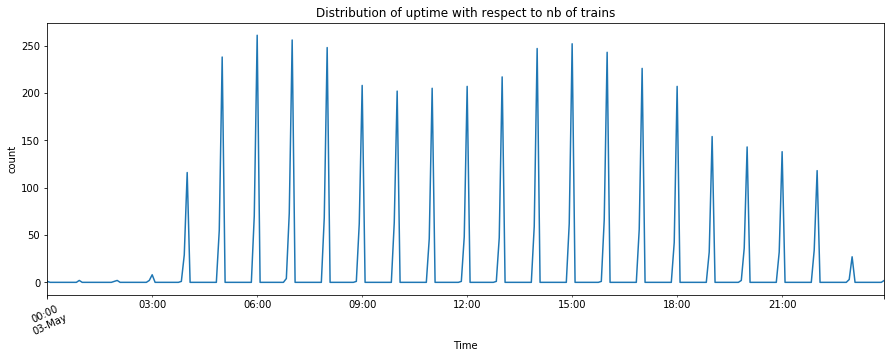

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,5])
ts_5m.plot()
plt.xlabel('Time')
plt.ylabel('count')
plt.xticks(rotation=25)
plt.title('Distribution of uptime with respect to nb of trains')
plt.show()

You can see there exists several peaks at the time 6:00 a.m. and 15:00 p.m. which can be converted to local time as 8:00 a.m. and 17:00 p.m. when people go out or go back home. 

Because we search offset with a margin of 1 hour. So that you will see the count of trains in up-time is centered around each hour.